# AdventureGame Evaluation
This notebook produces tables and plots to analyse AdventureGame results. All plots and tables appearing in the AdventureGame paper are created using the contained code.

In [2699]:
import sys
# sys.path.append('..')

from pathlib import Path

import json
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.colors import ListedColormap
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.patches import Polygon
from numpy.ma.extras import average

import evaluation.evalutils as utils
from evaluation.makingtables import build_dispersion_table
import evaluation.clemmetrics as clemmetrics

Choose path for the .csv with the raw scores. This is created after running ```bencheval.py```.

In [2700]:
RAW_PATH = Path('results/raw.csv')
raw_df = pd.read_csv(RAW_PATH, index_col=0)

Full results dataframe:

In [2701]:
raw_df

,game,model,experiment,episode,metric,value
0,adventuregame,Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Ins...,0_home_deliver_three_basic_easy,episode_0,Violated Request Count,0.0
1,adventuregame,Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Ins...,0_home_deliver_three_basic_easy,episode_0,Parsed Request Count,10.0
2,adventuregame,Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Ins...,0_home_deliver_three_basic_easy,episode_0,Request Count,10.0
3,adventuregame,Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Ins...,0_home_deliver_three_basic_easy,episode_0,Request Success Ratio,1.0
4,adventuregame,Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Ins...,0_home_deliver_three_basic_easy,episode_0,hallucination_count,0.0
...,...,...,...,...,...,...
44305,adventuregame,Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder...,9_new-words_home-delivery_medium_basic_medium,episode_5,Played,0.0
44306,adventuregame,Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder...,9_new-words_home-delivery_medium_basic_medium,episode_6,Played,0.0
44307,adventuregame,Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder...,9_new-words_home-delivery_medium_basic_medium,episode_7,Played,1.0
44308,adventuregame,Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder...,9_new-words_home-delivery_medium_basic_medium,episode_8,Played,0.0


Dictionaries for converting full model, experiment and score/metric names to compact names:

In [2702]:
model_name_dict = {
    # 'gemma-2-9b-it-GGUF-q5-t0.0--gemma-2-9b-it-GGUF-q5-t0.0': "gemma-2-9b-it-q5",
    # 'gemma-7b-it-Groq-t0.0--gemma-7b-it-Groq-t0.0': "gemma-7b-it",
    # 'gemma2-9b-it-Groq-t0.0--gemma2-9b-it-Groq-t0.0': "gemma2-9b-it",
    # 'Llama-3-70B-Instruct-Groq-t0.0--Llama-3-70B-Instruct-Groq-t0.0': "Llama-3-70B-Instruct",
    # 'Llama-3-8B-Instruct-Groq-t0.0--Llama-3-8B-Instruct-Groq-t0.0': "Llama-3-8B-Instruct",
    # 'llama-3.1-70b-versatile-Groq-t0.0--llama-3.1-70b-versatile-Groq-t0.0': "Llama-3.1-70b-Instruct",
    # 'llama-3.1-8b-instant-Groq-t0.0--llama-3.1-8b-instant-Groq-t0.0': "Llama-3.1-8b-Instruct",
    # 'LLaMA2-13B-Tiefighter-t0.0--LLaMA2-13B-Tiefighter-t0.0': "LLaMA2-13B-Tiefighter",
    # 'Meta-Llama-3.1-405B-Instruct-Turbo-TogetherAI-t0.0--Meta-Llama-3.1-405B-Instruct-Turbo-TogetherAI-t0.0': "Llama-3.1-405B-Instruct",
    # 'Mistral-Large-Instruct-2407-t0.0--Mistral-Large-Instruct-2407-t0.0': "Mistral-Large-Instruct-2407",
    # 'openchat_3.5-GGUF-q5-t0.0--openchat_3.5-GGUF-q5-t0.0': "openchat3.5-GGUF-q5",
    'openchat_3.5-GGUF-q8-t0.0--openchat_3.5-GGUF-q8-t0.0': 'openchat3.5-Q8',
    'openchat_3.5-t0.0--openchat_3.5-t0.0': "openchat3.5",
    # 'Qwen1.5-72B-Chat-t0.0--Qwen1.5-72B-Chat-t0.0': "Qwen1.5-72B-Chat",
    'Qwen2-72B-Instruct-t0.0--Qwen2-72B-Instruct-t0.0': "Qwen2-72B",
    'Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0': 'Llama-3.1-8B',
    'Meta-Llama-3-8B-Instruct-t0.0--Meta-Llama-3-8B-Instruct-t0.0': 'Llama-3-8B',
    'Qwen2.5-7B-Instruct-t0.0--Qwen2.5-7B-Instruct-t0.0': 'Qwen2.5-7B',
    'Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0': 'Qwen2.5-32B',
    'Qwen2.5-Coder-7B-Instruct-t0.0--Qwen2.5-Coder-7B-Instruct-t0.0': 'Qwen2.5C-7B',
    'Qwen2.5-72B-Instruct-t0.0--Qwen2.5-72B-Instruct-t0.0': 'Qwen2.5-72B',
    'Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0': 'Llama-3.3-70B',
    'Meta-Llama-3.1-70B-Instruct-t0.0--Meta-Llama-3.1-70B-Instruct-t0.0': 'Llama-3.1-70B',
    'Sky-T1-32B-Preview-t0.0--Sky-T1-32B-Preview-t0.0': 'Sky-T1-32B',
    'llama-3.1-405b-t0.0--llama-3.1-405b-t0.0': 'Llama-3.1-405B',
    'gpt-4o-2024-08-06-t0.0--gpt-4o-2024-08-06-t0.0': 'GPT-4o',
    'claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0': 'Claude-3.5',
    'qwen-max-t0.0--qwen-max-t0.0': 'Qwen-max',
    'gemini-2.0-flash-exp-t0.0--gemini-2.0-flash-exp-t0.0': 'Gemini-2.0',
    'deepseek-v3-t0.0--deepseek-v3-t0.0': 'DeepSeek-V3',
    'o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0': 'o3-mini'
}

top_models = [
    'o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0',
    'claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0',
    'gpt-4o-2024-08-06-t0.0--gpt-4o-2024-08-06-t0.0',
    'Meta-Llama-3.1-70B-Instruct-t0.0--Meta-Llama-3.1-70B-Instruct-t0.0',
    'Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0',
    'Qwen2-72B-Instruct-t0.0--Qwen2-72B-Instruct-t0.0',
    'Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0',
    'Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0',
    'Qwen2.5-72B-Instruct-t0.0--Qwen2.5-72B-Instruct-t0.0'
    ]

final_models = [
    # 'claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0',
    # 'o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0',
    # 'gpt-4o-2024-08-06-t0.0--gpt-4o-2024-08-06-t0.0',
    # 'qwen-max-t0.0--qwen-max-t0.0',
    'Meta-Llama-3.1-70B-Instruct-t0.0--Meta-Llama-3.1-70B-Instruct-t0.0',
    'Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0',
    # 'deepseek-v3-t0.0--deepseek-v3-t0.0',
    # 'llama-3.1-405b-t0.0--llama-3.1-405b-t0.0',
    'Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0',
    # 'gemini-2.0-flash-exp-t0.0--gemini-2.0-flash-exp-t0.0',
    'Qwen2-72B-Instruct-t0.0--Qwen2-72B-Instruct-t0.0',
    'Qwen2.5-72B-Instruct-t0.0--Qwen2.5-72B-Instruct-t0.0',
    'Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0',
    # 'Sky-T1-32B-Preview-t0.0--Sky-T1-32B-Preview-t0.0'
]

experiment_short_name_dict = {
    '0_home_deliver_three_basic_easy': "basic-easy",
    '1_home_deliver_three_planning_easy': "planning-easy",
    '2_home_deliver_three_basic_easy_invlimittwo': "basic-easy-invlimit",
    '3_home_deliver_three_planning_easy_invlimittwo': "planning-easy-invlimit",
    '4_home_deliver_three_basic_hard': "basic-hard",
    '5_home_deliver_three_planning_hard': "planning-hard",
    '6_home_deliver_three_basic_hard_invlimittwo': "basic-hard-invlimit",
    '7_home_deliver_three_planning_hard_invlimittwo': "planning-hard-invlimit",
    '8_new-words_home-delivery_easy_basic_easy': "new-words-easy",
    '9_new-words_home-delivery_medium_basic_medium': "new-words-medium",
    '10_new-words_created_basic_hard': "new-words-hard",
}

metric_name_dict = {
    'taking_from_inventory': "taking from inventory",
    'other_room_argument': "interacting with other room",
    'not_room_type': "going to non-existent room",
    'going_to_current_room': "going to current room",
    'no_exit_to': "going to non-adjacent room",
    'multiple_exits_to': "ambiguous traversal",
    'entity_already_inventory': "entity already in inventory",
    'thing_arg1_room': "first entity is room",
    'entity_not_accessible': "entity not accessible",
    'multiple_entity_ambiguity': "ambiguous entity",
    'thing_arg2_room': "second entity is room",
    'pre_state_mismatch': "main condition not fact",
    'action_parsing_fail': "parsing failure",
    'action_resolution_fail': "resolution failure",
    'lark_exception': "out of grammar",
    'malformed_command': "malformed command",
    'undefined_action_verb': "undefined action verb",
    'undefined_action': "undefined action type",
    'undefined_repr_str': "undefined noun",
    'manipulating_room': "manipulating room",
    'undefined_argument_type': "undefined antecedent",
    'successful_actions': "successful actions",
    'finish_speed': "finish speed",
    'domain_trait_type_mismatch': "domain mismatch",
    'domain_type_discrepancy': "domain discrepancy",
    'world_state_discrepancy': "world state discrepancy",
    'entity_state_mismatch': "entity state mismatch",
    'entity_trait_mismatch': "entity trait mismatch",
    'inventory_limit_exceeded': "inventory limit exceeded"
}

Dataframe containing only AdventureGame results (needed in case AdventureGame was run along with other clemgames), with short model and experiment names:

In [2703]:
game_df = raw_df[raw_df.game == 'adventuregame']
game_df = game_df.replace(model_name_dict).replace(experiment_short_name_dict)
game_df

,game,model,experiment,episode,metric,value
0,adventuregame,Llama-3.3-70B,basic-easy,episode_0,Violated Request Count,0.0
1,adventuregame,Llama-3.3-70B,basic-easy,episode_0,Parsed Request Count,10.0
2,adventuregame,Llama-3.3-70B,basic-easy,episode_0,Request Count,10.0
3,adventuregame,Llama-3.3-70B,basic-easy,episode_0,Request Success Ratio,1.0
4,adventuregame,Llama-3.3-70B,basic-easy,episode_0,hallucination_count,0.0
...,...,...,...,...,...,...
44305,adventuregame,Qwen2.5-32B,new-words-medium,episode_5,Played,0.0
44306,adventuregame,Qwen2.5-32B,new-words-medium,episode_6,Played,0.0
44307,adventuregame,Qwen2.5-32B,new-words-medium,episode_7,Played,1.0
44308,adventuregame,Qwen2.5-32B,new-words-medium,episode_8,Played,0.0


## Overall benchmark scores

In [2704]:
# read the clem scores
RESULTS_PATH = Path('results/results.csv')
clem_df = pd.read_csv(RESULTS_PATH, index_col=0)

Full overall score dataframe (useful in case other clemgames were run along with AdventureGame):

In [2705]:
clem_df = clem_df.rename(model_name_dict)
clem_df

,"-, clemscore","adventuregame, % Played","adventuregame, Quality Score","adventuregame, Quality Score (std)","all, Average % Played","all, Average Quality Score"
Llama-3.3-70B,41.84,90.91,46.02,49.98,90.91,46.02
Llama-3.1-70B,45.62,89.20,51.14,50.13,89.20,51.14
Llama-3.1-8B,7.09,35.43,20.00,40.11,35.43,20.00
Qwen2-72B,16.63,58.52,28.41,45.23,58.52,28.41
Qwen2.5-72B,12.51,57.95,21.59,41.26,57.95,21.59
Qwen2.5-32B,12.93,50.57,25.57,43.75,50.57,25.57


Overview dataframe, omitting averages for 'all games' (assumes only AdventureGame results present):

In [2706]:
overview_df = clem_df.rename(model_name_dict).drop(columns=["all, Average % Played", "all, Average Quality Score", "adventuregame, Quality Score (std)"]).sort_values(by='-, clemscore', ascending=False)
overview_short_columns = {"-, clemscore": "clemscore", "adventuregame, % Played": "% Played", "adventuregame, Quality Score": "Quality Score", "adventuregame, Quality Score (std)": "Quality Score (std)"}
overview_df = overview_df.rename(columns=overview_short_columns)
overview_df

,clemscore,% Played,Quality Score
Llama-3.1-70B,45.62,89.20,51.14
Llama-3.3-70B,41.84,90.91,46.02
Qwen2-72B,16.63,58.52,28.41
Qwen2.5-32B,12.93,50.57,25.57
Qwen2.5-72B,12.51,57.95,21.59
Llama-3.1-8B,7.09,35.43,20.00


In [2707]:
# get overall goal%:
goals_df = game_df.drop(columns=["game"])
# goals_df = goals_df.query('metric in ["Main Score", "Played", "achieved_goal_rating"]')
goals_df = goals_df.query('metric in ["achieved_goal_rating"]')

# goals_df = goals_df.query("model in ['o3-mini', 'Claude-3.5', 'Llama-3.1-70B', 'Qwen2.5-32B', 'GPT-4o']")

# goals_df = build_dispersion_table(['model', 'experiment', 'metric'], goals_df)
goals_df = build_dispersion_table(['model', 'metric'], goals_df)
# goals_df = build_dispersion_table(['model'], goals_df)

goals_df = goals_df.drop(columns=["var", "median", "max", "min", "skew", "std"])

goals_df = goals_df.rename({"achieved_goal_rating": "% Goals"})

goals_df = pd.pivot_table(goals_df, index=['model'], columns='metric')

# goals_df = goals_df.rename({'mean': '% Goals'})

goals_df[('metric', '% Goals')] = goals_df[('mean', '% Goals')]

goals_df = goals_df.drop(columns=[('mean', '% Goals')])

goals_df

,metric
metric,% Goals
model,
Llama-3.1-70B,67.613636
Llama-3.1-8B,35.238095
Llama-3.3-70B,66.098485
Qwen2-72B,48.863636
Qwen2.5-32B,48.295455
Qwen2.5-72B,46.401515


In [2708]:
# combined_df = pd.concat([overview_df, goals_col.rename("% Goals")], axis=1)
# combined_df = pd.concat([overview_df, goals_col], axis=1)
combined_df = pd.concat([overview_df, goals_df], axis=1)
# combined_df = combined_df.rename({'mean': '% Goals'})
combined_df

,clemscore,% Played,Quality Score,"(metric, % Goals)"
Llama-3.1-70B,45.62,89.20,51.14,67.613636
Llama-3.3-70B,41.84,90.91,46.02,66.098485
Qwen2-72B,16.63,58.52,28.41,48.863636
Qwen2.5-32B,12.93,50.57,25.57,48.295455
Qwen2.5-72B,12.51,57.95,21.59,46.401515
Llama-3.1-8B,7.09,35.43,20.00,35.238095


In [2709]:
combined_df.to_html("results/adventuregame_overview_table.html")

In [2710]:
combined_overview_styled = combined_df.style.set_table_styles([
    {'selector': 'toprule', 'props': ':hline;'},
    {'selector': 'bottomrule', 'props': ':hline;'},
# ], overwrite=False).format(subset="clemscore", precision=1).format(subset="% Played", precision=1).format(subset="Quality Score", precision=1).format(subset="('metric', '% Goals')", precision=1)
], overwrite=False).format(precision=1)
combined_overview_styled.to_latex('results/adventuregame_overview_table.tex')

In [2711]:
overview_df.to_html("results/adventuregame_overview_table.html")
overview_df.to_csv("results/adventuregame_overview_table.csv")

In [2712]:
overview_styled = overview_df.style.set_table_styles([
    {'selector': 'toprule', 'props': ':hline;'},
    {'selector': 'bottomrule', 'props': ':hline;'},
], overwrite=False).format(subset="clemscore", precision=1).format(subset="% Played", precision=1).format(subset="Quality Score", precision=1)
overview_styled.to_latex('results/adventuregame_overview_table.tex')

Model comparison stacked bar plot:

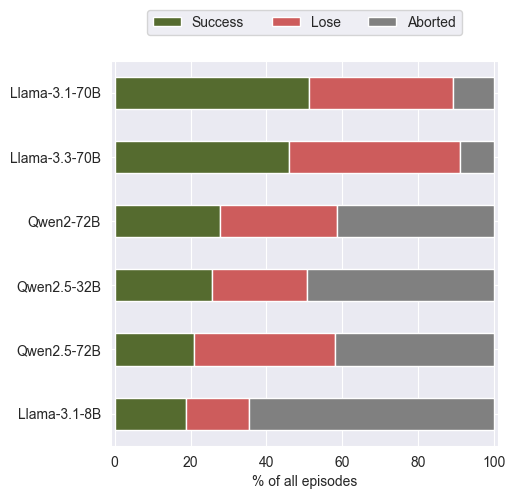

In [2713]:
STACK_COLORS = ['darkolivegreen', 'indianred', 'gray']

df_aux = raw_df[raw_df.metric.isin(utils.GAMEPLAY_METRICS)]

df_aux = df_aux.replace(model_name_dict)

df_aux = df_aux[~df_aux.model.str.contains('openchat')]
df_aux = df_aux[~df_aux.model.str.contains('Qwen2.5-7B')]
df_aux = df_aux[~df_aux.model.str.contains('Qwen2.5C-7B')]
df_aux = df_aux[~df_aux.model.str.contains('Llama-3-8B')]


clem_df_cull = clem_df[~clem_df.index.str.contains('openchat')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Qwen2.5-7B')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Qwen2.5C-7B')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Llama-3-8B')]


df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
order = clem_df_cull.sort_values(by='-, clemscore').index
percs = percs.reindex(order)

percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=3)
plt.xlabel('% of all episodes')
plt.xlim(-1, 101)
plt.ylabel('')

plt.savefig("results/episode_overview_stack.pdf", format="pdf", bbox_inches="tight")

plt.show()

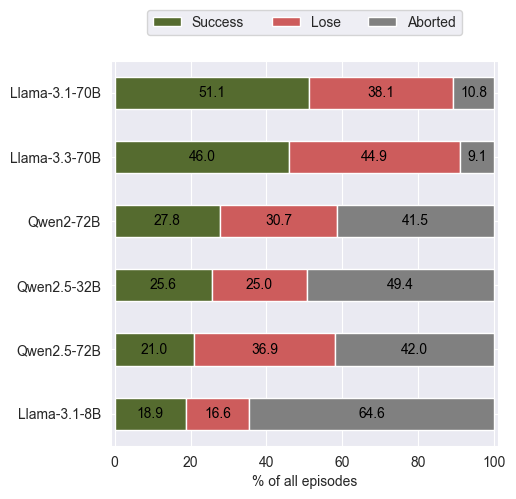

In [2714]:
STACK_COLORS = ['darkolivegreen', 'indianred', 'gray']

df_aux = raw_df[raw_df.metric.isin(utils.GAMEPLAY_METRICS)]

df_aux = df_aux.replace(model_name_dict)

df_aux = df_aux[~df_aux.model.str.contains('openchat')]
df_aux = df_aux[~df_aux.model.str.contains('Qwen2.5-7B')]
df_aux = df_aux[~df_aux.model.str.contains('Qwen2.5C-7B')]
df_aux = df_aux[~df_aux.model.str.contains('Llama-3-8B')]


clem_df_cull = clem_df[~clem_df.index.str.contains('openchat')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Qwen2.5-7B')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Qwen2.5C-7B')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Llama-3-8B')]


df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
order = clem_df_cull.sort_values(by='-, clemscore').index
percs = percs.reindex(order)

stacks = percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))

# print(stacks.__dict__)
# plt.bar_label(stacks, label_type='center')
# stacks.bar_label(percs)
for bar in stacks.containers:
    labels = [np.round(v.get_width(), 1) for v in bar]
    # labels = [v for v in bar]
    # for v in bar:
    #    print(v)
    #    print(v.get_width())
    #    print(type(v.get_width()))
    stacks.bar_label(bar, labels=labels, label_type='center', color='black')
    # stacks.bar_label(bar, label_type='center', color='black')


plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=3)
plt.xlabel('% of all episodes')
plt.xlim(-1, 101)
plt.ylabel('')

plt.savefig("results/episode_overview_stack.pdf", format="pdf", bbox_inches="tight")

plt.show()

Bar plot with sorted clemscores:

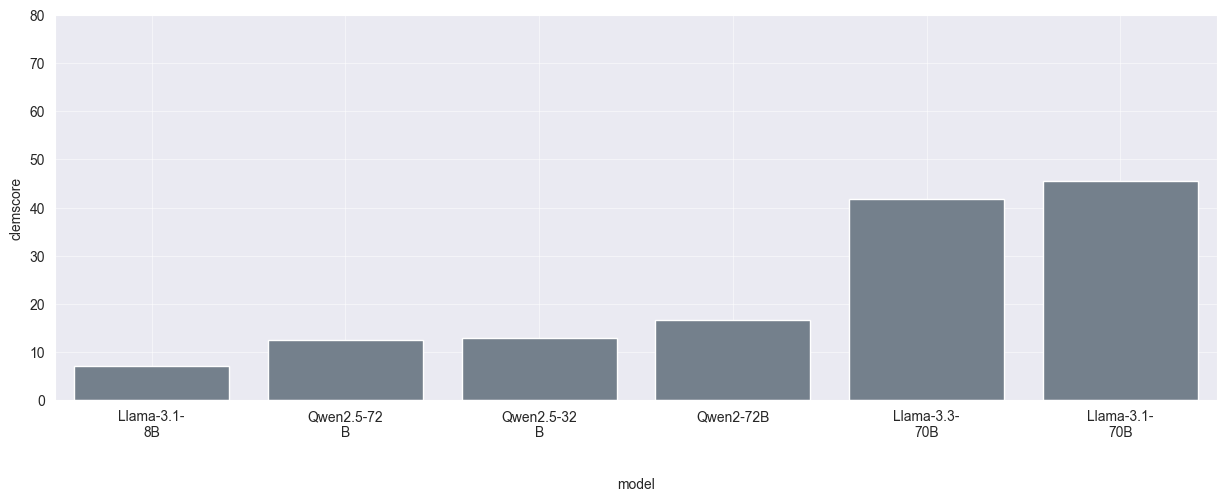

In [2715]:
clem_aux = clem_df.sort_values(by='-, clemscore').reset_index(names='model').replace(model_name_dict)
# warning, if models have matching names up the limit, results will be wrongly merged!
clem_aux['model'] = clem_aux['model'].apply(lambda x: f'{x[:10]}\n{x[10:20]}\n{x[20:30]}\n{x[30:]}')

fig = plt.figure(figsize=(15, 5))
sns.barplot(clem_aux, x='model', y='-, clemscore', color='slategray')
# plt.ylim(-5, 105)
plt.ylim(0, 80)
plt.ylabel('clemscore')
plt.grid(alpha=0.5)
plt.show()

Omit models for which all episodes were aborted due to not following prompted format for detail analysis:

In [2716]:
all_abort_models = ["LLaMA2-13B-Tiefighter"]
game_df = game_df.query('model not in ["LLaMA2-13B-Tiefighter"]')
game_df

,game,model,experiment,episode,metric,value
0,adventuregame,Llama-3.3-70B,basic-easy,episode_0,Violated Request Count,0.0
1,adventuregame,Llama-3.3-70B,basic-easy,episode_0,Parsed Request Count,10.0
2,adventuregame,Llama-3.3-70B,basic-easy,episode_0,Request Count,10.0
3,adventuregame,Llama-3.3-70B,basic-easy,episode_0,Request Success Ratio,1.0
4,adventuregame,Llama-3.3-70B,basic-easy,episode_0,hallucination_count,0.0
...,...,...,...,...,...,...
44305,adventuregame,Qwen2.5-32B,new-words-medium,episode_5,Played,0.0
44306,adventuregame,Qwen2.5-32B,new-words-medium,episode_6,Played,0.0
44307,adventuregame,Qwen2.5-32B,new-words-medium,episode_7,Played,1.0
44308,adventuregame,Qwen2.5-32B,new-words-medium,episode_8,Played,0.0


## Failure metrics
### Failures by IF interpreter phase

In [2717]:
failures_by_phase_df = game_df.query('metric in ["action_parsing_fail", "action_resolution_fail"]')
failures_by_phase_df

,game,model,experiment,episode,metric,value
5,adventuregame,Llama-3.3-70B,basic-easy,episode_0,action_parsing_fail,0.0
6,adventuregame,Llama-3.3-70B,basic-easy,episode_0,action_resolution_fail,0.0
46,adventuregame,Llama-3.3-70B,basic-easy,episode_1,action_parsing_fail,0.0
47,adventuregame,Llama-3.3-70B,basic-easy,episode_1,action_resolution_fail,2.0
87,adventuregame,Llama-3.3-70B,basic-easy,episode_10,action_parsing_fail,0.0
...,...,...,...,...,...,...
43138,adventuregame,Qwen2.5-32B,new-words-medium,episode_7,action_resolution_fail,3.0
43178,adventuregame,Qwen2.5-32B,new-words-medium,episode_8,action_parsing_fail,46.0
43179,adventuregame,Qwen2.5-32B,new-words-medium,episode_8,action_resolution_fail,1.0
43219,adventuregame,Qwen2.5-32B,new-words-medium,episode_9,action_parsing_fail,5.0


Bar plot showing failures by phase for all models over all experiments:

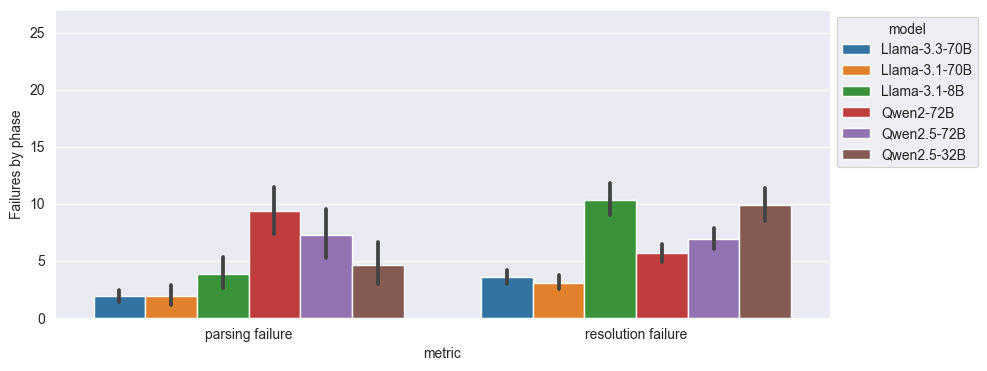

In [2718]:
fig, ax = plt.subplots(figsize=(10, 4))

g = sns.barplot(failures_by_phase_df.replace(metric_name_dict),
                x='metric',
                y='value',
                hue='model',
                ax=ax)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.ylim(0, 27)
plt.ylabel("Failures by phase")

plt.show()

Dataframe with parsed request counts, ie actions passed to the IF interpreter (used to calculate failure ratios):

In [2719]:
parsed_df = game_df[game_df.metric == "Parsed Request Count"].groupby(["model"]).sum()
parsed_df = parsed_df.drop(columns=["game", 'experiment', 'episode', 'metric'])
parsed_df

,value
model,
Llama-3.1-70B,4265.0
Llama-3.1-8B,6080.0
Llama-3.3-70B,4303.0
Qwen2-72B,5693.0
Qwen2.5-32B,6315.0
Qwen2.5-72B,6060.0


Counts of failures by phase for all models over all experiments:

In [2720]:
failures_by_phase_counts = failures_by_phase_df.replace(metric_name_dict).groupby(['model', 'metric']).sum()
failures_by_phase_counts = failures_by_phase_counts.drop(columns=["game", 'experiment', 'episode'])
failures_by_phase_counts

value
model         metric                    
Llama-3.1-70B parsing failure      332.0
              resolution failure   543.0
Llama-3.1-8B  parsing failure      675.0
              resolution failure  1812.0
Llama-3.3-70B parsing failure      330.0
              resolution failure   632.0
Qwen2-72B     parsing failure     1644.0
              resolution failure   991.0
Qwen2.5-32B   parsing failure      816.0
              resolution failure  1735.0
Qwen2.5-72B   parsing failure     1269.0
              resolution failure  1217.0

Ratios of failures by phase for all models over all experiments (calculated by dividing failures counts by parsed request counts):

In [2721]:
failures_by_phase_ratios = failures_by_phase_counts / parsed_df
failures_by_phase_ratios

value
model         metric                      
Llama-3.1-70B parsing failure     0.077843
              resolution failure  0.127315
Llama-3.1-8B  parsing failure     0.111020
              resolution failure  0.298026
Llama-3.3-70B parsing failure     0.076691
              resolution failure  0.146874
Qwen2-72B     parsing failure     0.288776
              resolution failure  0.174073
Qwen2.5-32B   parsing failure     0.129216
              resolution failure  0.274743
Qwen2.5-72B   parsing failure     0.209406
              resolution failure  0.200825

Overview/model comparison stacked bar plot for successful actions and failures by phase:

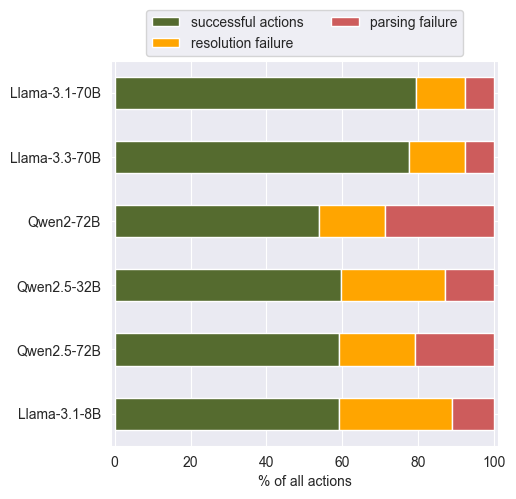

In [2722]:
STACK_COLORS = ['darkolivegreen', 'orange', 'indianred']

phase_failures = ["action_parsing_fail", "action_resolution_fail", "successful_actions"]

df_aux = game_df[game_df.metric.isin(phase_failures)]
df_aux = df_aux.replace(metric_name_dict)


df_aux = df_aux[~df_aux.model.str.contains('openchat')]
df_aux = df_aux[~df_aux.model.str.contains('Qwen2.5-7B')]
df_aux = df_aux[~df_aux.model.str.contains('Qwen2.5C-7B')]
df_aux = df_aux[~df_aux.model.str.contains('Llama-3-8B')]


clem_df_cull = clem_df[~clem_df.index.str.contains('openchat')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Qwen2.5-7B')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Qwen2.5C-7B')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Llama-3-8B')]


df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
order = clem_df_cull.query('index not in ["LLaMA2-13B-Tiefighter"]').sort_values(by='-, clemscore').index
percs = percs.reindex(order)

percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=2)
plt.xlabel('% of all actions')
plt.xlim(-1, 101)
plt.ylabel('')

plt.savefig("results/action_overview_stack.pdf", format="pdf", bbox_inches="tight")

plt.show()

### Parsing failures
Dataframe with parsing failure counts/ratios:
Note: While "undefined_action" and "undefined_argument_type" did not occur in the v1 results, they are implemented, and thus not omitted here.

In [2723]:
parsing_failures_df = game_df.query('metric in ["lark_exception", "malformed_command", "undefined_action", "undefined_action_verb", "undefined_repr_str", "undefined_argument_type"]')
parsing_failures_df = parsing_failures_df.replace(metric_name_dict)
parsing_failures_counts = parsing_failures_df.groupby(['model', 'metric']).sum()
parsing_failures_counts = parsing_failures_counts.drop(columns=["game", 'experiment', 'episode'])
parsing_failures_counts['Ratio'] = parsing_failures_counts / parsed_df
parsing_failures_counts = parsing_failures_counts.rename(columns={"value": "Count"})
parsing_failures_counts

Count     Ratio
model         metric                                 
Llama-3.1-70B malformed command       196.0  0.045955
              out of grammar            5.0  0.001172
              undefined action type     0.0  0.000000
              undefined action verb   112.0  0.026260
              undefined antecedent      0.0  0.000000
              undefined noun           17.0  0.003986
Llama-3.1-8B  malformed command       401.0  0.065954
              out of grammar           21.0  0.003454
              undefined action type     0.0  0.000000
              undefined action verb   135.0  0.022204
              undefined antecedent      0.0  0.000000
              undefined noun          102.0  0.016776
Llama-3.3-70B malformed command       122.0  0.028352
              out of grammar           31.0  0.007204
              undefined action type     0.0  0.000000
              undefined action verb   118.0  0.027423
              undefined antecedent      0.0  0.000000
              undefined noun           55.0  0.012782
Qwen2-72B     malformed command       262.0  0.046021
              out of grammar          122.0  0.021430
              undefined action type     0.0  0.000000
              undefined action verb  1118.0  0.196382
              undefined antecedent      0.0  0.000000
              undefined noun          123.0  0.021605
Qwen2.5-32B   malformed command       241.0  0.038163
              out of grammar            0.0  0.000000
              undefined action type     0.0  0.000000
              undefined action verb   475.0  0.075218
              undefined antecedent      0.0  0.000000
              undefined noun           99.0  0.015677
Qwen2.5-72B   malformed command       416.0  0.068647
              out of grammar          102.0  0.016832
              undefined action type     0.0  0.000000
              undefined action verb   557.0  0.091914
              undefined antecedent      0.0  0.000000
              undefined noun          150.0  0.024752

In [2724]:
parsing_failures_counts.style.format(subset="Count", precision=0).format(subset="Ratio", precision=3).to_latex('results/parsing_failures_table.tex', clines="skip-last;data")

Overview/model comparison stacked bar plot for parsing failures:
Note: Non-occurring parsing failure types are omitted here.

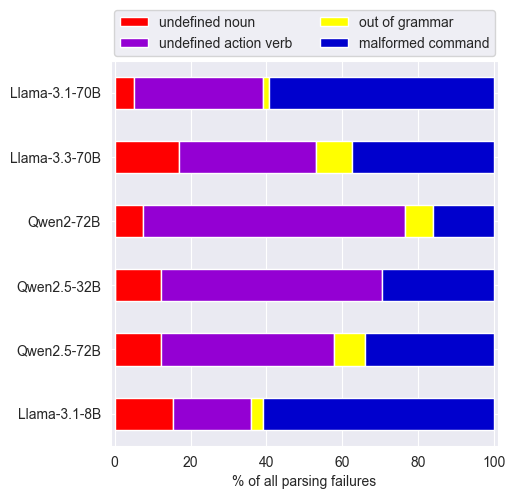

In [2725]:
STACK_COLORS = ['red', 'darkviolet', 'yellow', 'mediumblue']

parse_failures = ["lark_exception", "malformed_command", "undefined_action_verb", "undefined_repr_str"]

df_aux = game_df[game_df.metric.isin(parse_failures)]
df_aux = df_aux.replace(metric_name_dict)

df_aux = df_aux[~df_aux.model.str.contains('openchat')]
df_aux = df_aux[~df_aux.model.str.contains('Qwen2.5-7B')]
df_aux = df_aux[~df_aux.model.str.contains('Qwen2.5C-7B')]
df_aux = df_aux[~df_aux.model.str.contains('Llama-3-8B')]


clem_df_cull = clem_df[~clem_df.index.str.contains('openchat')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Qwen2.5-7B')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Qwen2.5C-7B')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Llama-3-8B')]



df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
order = clem_df_cull.query('index not in ["LLaMA2-13B-Tiefighter"]').sort_values(by='-, clemscore').index
percs = percs.reindex(order)

percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=2)
plt.xlabel('% of all parsing failures')
plt.xlim(-1, 101)
plt.ylabel('')

plt.savefig("results/parsing_failures_stack.pdf", format="pdf", bbox_inches="tight")

plt.show()

### Room/navigation failures
Dataframe with room/navigation failure counts/ratios:
Note: While "thing_arg1_room" and "thing_arg2_room" did not occur in the v1 results, they are implemented, and thus not omitted here.

In [2726]:
room_failures_df = game_df.query('metric in ["not_room_type", "no_exit_to", "manipulating_room", "other_room_argument", "thing_arg1_room", "thing_arg2_room"]')
room_failures_df = room_failures_df.replace(metric_name_dict)
room_failures_counts = room_failures_df.groupby(['model', 'metric']).sum()
room_failures_counts = room_failures_counts.drop(columns=["game", 'experiment', 'episode'])
room_failures_counts['ratio'] = room_failures_counts / parsed_df
room_failures_counts

value     ratio
model         metric                                      
Llama-3.1-70B going to non-adjacent room   201.0  0.047128
              interacting with other room    2.0  0.000469
              manipulating room              0.0  0.000000
Llama-3.1-8B  going to non-adjacent room   608.0  0.100000
              interacting with other room   15.0  0.002467
              manipulating room              0.0  0.000000
Llama-3.3-70B going to non-adjacent room   256.0  0.059493
              interacting with other room    4.0  0.000930
              manipulating room              0.0  0.000000
Qwen2-72B     going to non-adjacent room   456.0  0.080098
              interacting with other room   15.0  0.002635
              manipulating room              0.0  0.000000
Qwen2.5-32B   going to non-adjacent room   740.0  0.117181
              interacting with other room    0.0  0.000000
              manipulating room              1.0  0.000158
Qwen2.5-72B   going to non-adjacent room   532.0  0.087789
              interacting with other room   22.0  0.003630
              manipulating room              0.0  0.000000

Overview/model comparison stacked bar plot for room/navigation failures:
Note: Non-occurring room/navigation failure types are omitted here.

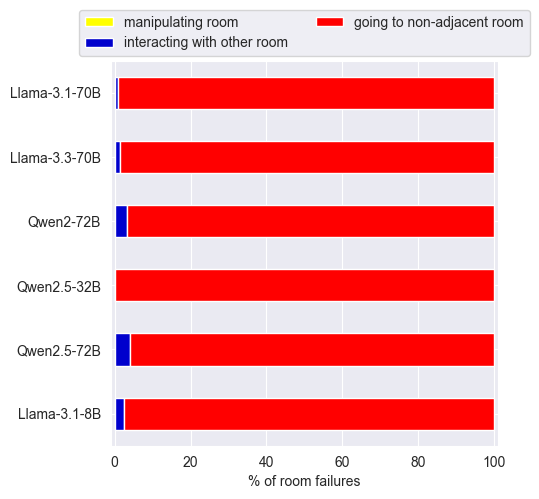

In [2727]:
STACK_COLORS = ['yellow', 'darkviolet', 'red', 'mediumblue', 'yellow', 'red']

room_failures = ["not_room_type", "no_exit_to", "manipulating_room", "other_room_argument"]

df_aux = game_df[game_df.metric.isin(room_failures)]
df_aux = df_aux.replace(metric_name_dict)


df_aux = df_aux[~df_aux.model.str.contains('openchat')]
df_aux = df_aux[~df_aux.model.str.contains('Qwen2.5-7B')]
df_aux = df_aux[~df_aux.model.str.contains('Qwen2.5C-7B')]
df_aux = df_aux[~df_aux.model.str.contains('Llama-3-8B')]


clem_df_cull = clem_df[~clem_df.index.str.contains('openchat')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Qwen2.5-7B')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Qwen2.5C-7B')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Llama-3-8B')]


df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
order = clem_df_cull.query('index not in ["LLaMA2-13B-Tiefighter"]').sort_values(by='-, clemscore').index
percs = percs.reindex(order)

percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=2)
plt.xlabel('% of room failures')
plt.xlim(-1, 101)
plt.ylabel('')

plt.savefig("results/nav_failures_stack.pdf", format="pdf", bbox_inches="tight")

plt.show()

### Entity-related failures
Dataframe with entity-related failure counts/ratios:

In [2728]:
entity_failures_df = game_df.query('metric in ["entity_not_accessible", "entity_already_inventory", "entity_state_mismatch", "entity_trait_mismatch", "inventory_limit_exceeded"]')
entity_failures_df = entity_failures_df.replace(metric_name_dict)
entity_failures_counts = entity_failures_df.groupby(['model', 'metric']).sum()
entity_failures_counts = entity_failures_counts.drop(columns=["game", 'experiment', 'episode'])
entity_failures_counts['ratio'] = entity_failures_counts / parsed_df
entity_failures_counts

value     ratio
model         metric                                      
Llama-3.1-70B entity already in inventory    6.0  0.001407
              entity not accessible        158.0  0.037046
              entity state mismatch        147.0  0.034467
              entity trait mismatch          6.0  0.001407
              inventory limit exceeded      14.0  0.003283
Llama-3.1-8B  entity already in inventory    5.0  0.000822
              entity not accessible        889.0  0.146217
              entity state mismatch        258.0  0.042434
              entity trait mismatch          2.0  0.000329
              inventory limit exceeded      25.0  0.004112
Llama-3.3-70B entity already in inventory    7.0  0.001627
              entity not accessible        149.0  0.034627
              entity state mismatch        180.0  0.041831
              entity trait mismatch          3.0  0.000697
              inventory limit exceeded      19.0  0.004416
Qwen2-72B     entity already in inventory   78.0  0.013701
              entity not accessible        292.0  0.051291
              entity state mismatch        127.0  0.022308
              entity trait mismatch          0.0  0.000000
              inventory limit exceeded      11.0  0.001932
Qwen2.5-32B   entity already in inventory    6.0  0.000950
              entity not accessible        586.0  0.092795
              entity state mismatch        336.0  0.053207
              entity trait mismatch          1.0  0.000158
              inventory limit exceeded      32.0  0.005067
Qwen2.5-72B   entity already in inventory  103.0  0.016997
              entity not accessible        426.0  0.070297
              entity state mismatch        133.0  0.021947
              entity trait mismatch          5.0  0.000825
              inventory limit exceeded       8.0  0.001320

Overview/model comparison stacked bar plot for entity-related failures:

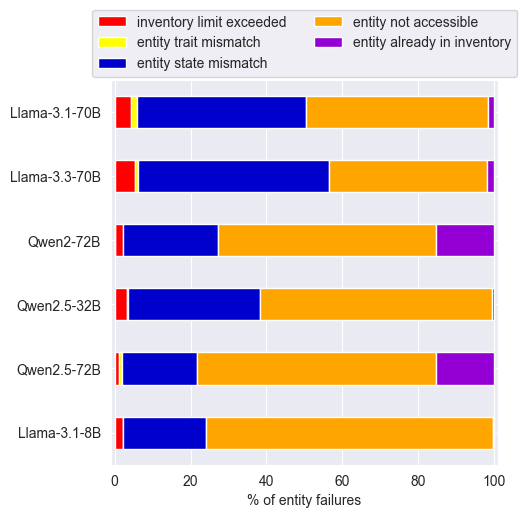

In [2729]:
STACK_COLORS = ['red', 'yellow', 'khaki', 'mediumblue','orange',  'darkviolet']

entity_failures = ["entity_not_accessible", "entity_already_inventory", "entity_state_mismatch", "entity_trait_mismatch", "inventory_limit_exceeded"]

df_aux = game_df[game_df.metric.isin(entity_failures)]
df_aux = df_aux.replace(metric_name_dict)


df_aux = df_aux[~df_aux.model.str.contains('openchat')]
df_aux = df_aux[~df_aux.model.str.contains('Qwen2.5-7B')]
df_aux = df_aux[~df_aux.model.str.contains('Qwen2.5C-7B')]
df_aux = df_aux[~df_aux.model.str.contains('Llama-3-8B')]


clem_df_cull = clem_df[~clem_df.index.str.contains('openchat')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Qwen2.5-7B')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Qwen2.5C-7B')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Llama-3-8B')]


df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
order = clem_df_cull.query('index not in ["LLaMA2-13B-Tiefighter"]').sort_values(by='-, clemscore').index
percs = percs.reindex(order)

percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncols=2)
plt.xlabel('% of entity failures')
plt.xlim(-1, 101)
plt.ylabel('')

plt.savefig("results/entity_failures_stack.pdf", format="pdf", bbox_inches="tight")

plt.show()

## Overview tables
Dispersion metrics over all episodes. Note that this uses groupby, which will ignore NaN values, according to the clembench documentation!

In [2730]:
stats_df = build_dispersion_table(['game', 'model', 'metric'], game_df) # could also use raw_df for results for all games
stats_df

mean        std   
game          model         metric                                          
adventuregame Llama-3.1-70B Aborted                   0.107955   0.311208  \
                            Lose                      0.380682   0.486940   
                            Main Score               51.136364  50.129702   
                            Parsed Request Count     24.232955  11.420145   
                            Played                    0.892045   0.311208   
...                                                        ...        ...   
              Qwen2.5-72B   undefined_action          0.000000   0.000000   
                            undefined_action_verb     3.164773   7.576739   
                            undefined_argument_type   0.000000   0.000000   
                            undefined_repr_str        0.852273   2.456663   
                            world_state_discrepancy   0.000000   0.000000   

                                                             var  median   
game          model         metric                                         
adventuregame Llama-3.1-70B Aborted                     0.096851     0.0  \
                            Lose                        0.237110     0.0   
                            Main Score               2512.987013   100.0   
                            Parsed Request Count      130.419708    22.0   
                            Played                      0.096851     1.0   
...                                                          ...     ...   
              Qwen2.5-72B   undefined_action            0.000000     0.0   
                            undefined_action_verb      57.406981     0.0   
                            undefined_argument_type     0.000000     0.0   
                            undefined_repr_str          6.035195     0.0   
                            world_state_discrepancy     0.000000     0.0   

                                                       max  min      skew  
game          model         metric                                         
adventuregame Llama-3.1-70B Aborted                    1.0  0.0  2.548464  
                            Lose                       1.0  0.0  0.495707  
                            Main Score               100.0  0.0 -0.045858  
                            Parsed Request Count      50.0  6.0  0.972001  
                            Played                     1.0  0.0 -2.548464  
...                                                    ...  ...       ...  
              Qwen2.5-72B   undefined_action           0.0  0.0  0.000000  
                            undefined_action_verb     43.0  0.0  3.259025  
                            undefined_argument_type    0.0  0.0  0.000000  
                            undefined_repr_str        21.0  0.0  5.379286  
                            world_state_discrepancy    0.0  0.0  0.000000  

[252 rows x 7 columns]

In [2731]:
failure_stats_by_phase_df = stats_df.query('metric in ["action_parsing_fail", "action_resolution_fail"]')
failure_stats_by_phase_df

mean        std   
game          model         metric                                         
adventuregame Llama-3.1-70B action_parsing_fail      1.886364   5.919328  \
                            action_resolution_fail   3.085227   4.115283   
              Llama-3.1-8B  action_parsing_fail      3.857143   9.116560   
                            action_resolution_fail  10.354286   8.934640   
              Llama-3.3-70B action_parsing_fail      1.875000   3.659235   
                            action_resolution_fail   3.590909   4.180598   
              Qwen2-72B     action_parsing_fail      9.340909  14.541280   
                            action_resolution_fail   5.630682   5.422174   
              Qwen2.5-32B   action_parsing_fail      4.636364  12.445246   
                            action_resolution_fail   9.857955  10.216359   
              Qwen2.5-72B   action_parsing_fail      7.210227  13.686536   
                            action_resolution_fail   6.914773   6.411473   

                                                           var  median   max   
game          model         metric                                             
adventuregame Llama-3.1-70B action_parsing_fail      35.038442     0.0  44.0  \
                            action_resolution_fail   16.935552     2.0  26.0   
              Llama-3.1-8B  action_parsing_fail      83.111658     0.0  50.0   
                            action_resolution_fail   79.827783     8.0  39.0   
              Llama-3.3-70B action_parsing_fail      13.390000     0.0  21.0   
                            action_resolution_fail   17.477403     2.0  28.0   
              Qwen2-72B     action_parsing_fail     211.448831     2.0  50.0   
                            action_resolution_fail   29.399968     4.0  33.0   
              Qwen2.5-32B   action_parsing_fail     154.884156     0.0  50.0   
                            action_resolution_fail  104.373994     6.0  49.0   
              Qwen2.5-72B   action_parsing_fail     187.321266     1.0  50.0   
                            action_resolution_fail   41.106981     5.0  35.0   

                                                    min      skew  
game          model         metric                                 
adventuregame Llama-3.1-70B action_parsing_fail     0.0  4.537733  
                            action_resolution_fail  0.0  3.192177  
              Llama-3.1-8B  action_parsing_fail     0.0  3.569332  
                            action_resolution_fail  0.0  0.833874  
              Llama-3.3-70B action_parsing_fail     0.0  2.857954  
                            action_resolution_fail  0.0  2.642122  
              Qwen2-72B     action_parsing_fail     0.0  1.703228  
                            action_resolution_fail  0.0  1.391161  
              Qwen2.5-32B   action_parsing_fail     0.0  2.884783  
                            action_resolution_fail  0.0  1.645465  
              Qwen2.5-72B   action_parsing_fail     0.0  2.288890  
                            action_resolution_fail  0.0  1.214135

Break results down by experiment:

In [2732]:
detailed_stats_df = build_dispersion_table(['game', 'model', 'experiment', 'metric'], game_df) # could also use raw_df for results for all games
detailed_stats_df

mean   
game          model         experiment             metric                             
adventuregame Llama-3.1-70B basic-easy             Aborted                   0.0000  \
                                                   Lose                      0.3750   
                                                   Main Score               62.5000   
                                                   Parsed Request Count     13.5625   
                                                   Played                    1.0000   
...                                                                             ...   
              Qwen2.5-72B   planning-hard-invlimit undefined_action          0.0000   
                                                   undefined_action_verb     1.7500   
                                                   undefined_argument_type   0.0000   
                                                   undefined_repr_str        0.8750   
                                                   world_state_discrepancy   0.0000   

                                                                                  std   
game          model         experiment             metric                               
adventuregame Llama-3.1-70B basic-easy             Aborted                   0.000000  \
                                                   Lose                      0.500000   
                                                   Main Score               50.000000   
                                                   Parsed Request Count      2.528998   
                                                   Played                    0.000000   
...                                                                               ...   
              Qwen2.5-72B   planning-hard-invlimit undefined_action          0.000000   
                                                   undefined_action_verb     1.983263   
                                                   undefined_argument_type   0.000000   
                                                   undefined_repr_str        1.784190   
                                                   world_state_discrepancy   0.000000   

                                                                                    var   
game          model         experiment             metric                                 
adventuregame Llama-3.1-70B basic-easy             Aborted                     0.000000  \
                                                   Lose                        0.250000   
                                                   Main Score               2500.000000   
                                                   Parsed Request Count        6.395833   
                                                   Played                      0.000000   
...                                                                                 ...   
              Qwen2.5-72B   planning-hard-invlimit undefined_action            0.000000   
                                                   undefined_action_verb       3.933333   
                                                   undefined_argument_type     0.000000   
                                                   undefined_repr_str          3.183333   
                                                   world_state_discrepancy     0.000000   

                                                                            median   
game          model         experiment             metric                            
adventuregame Llama-3.1-70B basic-easy             Aborted                     0.0  \
                                                   Lose                        0.0   
                                                   Main Score                100.0   
                                                   Parsed Request Count       14.0   
                                                   Played                      1.0   
...

In [2733]:
stats_df.to_csv('results/adventuregame_stats.csv')
detailed_stats_df.to_csv('results/adventuregame_stats_detailed.csv')

In [2734]:
stats_df.to_html('results/adventuregame_stats.html')
detailed_stats_df.to_html('results/adventuregame_stats_detailed.html')

Condensed tables:

In [2735]:
game_df

,game,model,experiment,episode,metric,value
0,adventuregame,Llama-3.3-70B,basic-easy,episode_0,Violated Request Count,0.0
1,adventuregame,Llama-3.3-70B,basic-easy,episode_0,Parsed Request Count,10.0
2,adventuregame,Llama-3.3-70B,basic-easy,episode_0,Request Count,10.0
3,adventuregame,Llama-3.3-70B,basic-easy,episode_0,Request Success Ratio,1.0
4,adventuregame,Llama-3.3-70B,basic-easy,episode_0,hallucination_count,0.0
...,...,...,...,...,...,...
44305,adventuregame,Qwen2.5-32B,new-words-medium,episode_5,Played,0.0
44306,adventuregame,Qwen2.5-32B,new-words-medium,episode_6,Played,0.0
44307,adventuregame,Qwen2.5-32B,new-words-medium,episode_7,Played,1.0
44308,adventuregame,Qwen2.5-32B,new-words-medium,episode_8,Played,0.0


In [2736]:
selected_stats_df = game_df.drop(columns=["game"])
selected_metrics_list = ["Main Score", "Played", "Success", "action_parsing_fail", "action_resolution_fail", "successful_actions"]
selected_stats_df = selected_stats_df.query('metric in ["Main Score", "Played"]')
selected_stats_df = build_dispersion_table(['model', 'experiment', 'metric'], selected_stats_df)
selected_stats_df = selected_stats_df.drop(columns=["var", "median", "max", "min", "skew"])
selected_stats_df = selected_stats_df.rename(metric_name_dict)
selected_stats_df = selected_stats_df.rename({"Main Score": "Score"})
selected_stats_df = selected_stats_df.reset_index()
selected_stats_df = pd.pivot_table(selected_stats_df, index=['model', 'experiment'], columns='metric')
selected_stats_df

mean              std           
metric                                Played  Score    Played      Score
model         experiment                                                
Llama-3.1-70B basic-easy              1.0000  62.50  0.000000  50.000000
              basic-easy-invlimit     1.0000  62.50  0.000000  50.000000
              basic-hard              0.8750  31.25  0.341565  47.871355
              basic-hard-invlimit     0.8750  37.50  0.341565  50.000000
              new-words-easy          0.9375  68.75  0.250000  47.871355
...                                      ...    ...       ...        ...
Qwen2.5-72B   new-words-medium        0.1875   0.00  0.403113   0.000000
              planning-easy           0.8125  37.50  0.403113  50.000000
              planning-easy-invlimit  0.9375  56.25  0.250000  51.234754
              planning-hard           0.4375  31.25  0.512348  47.871355
              planning-hard-invlimit  0.6875  18.75  0.478714  40.311289

[66 rows x 4 columns]

In [2737]:
selected_stats_df.to_html("results/selected_stats.html")

In [2738]:
selected_stats_styled = selected_stats_df.style.set_table_styles([
    {'selector': 'toprule', 'props': ':hline;'},
    {'selector': 'bottomrule', 'props': ':hline;'},
], overwrite=False).format(precision=2)
selected_stats_styled.to_latex("results/selected_stats.tex", clines="skip-last;data")

Limit to selected top models:

In [2739]:
top_stats_df = game_df.drop(columns=["game"])
# top_stats_df = top_stats_df.query('metric in ["Main Score", "Played", "Success", "hallucination_count"]')
# top_stats_df = top_stats_df.query('metric in ["Main Score", "Played", "achieved_goal_rating"]')
top_stats_df = top_stats_df.query('metric in ["Main Score", "Played", "achieved_goal_rating", "plan_average_viability_ratio", "hallucination_count"]')
top_stats_df = top_stats_df.query("model in ['o3-mini', 'Claude-3.5', 'Llama-3.1-70B', 'Qwen2.5-32B', 'GPT-4o', 'Llama-3.1-8B', 'Qwen2.5-72B', 'Llama-3.3-70B']")
top_stats_df = build_dispersion_table(['model', 'experiment', 'metric'], top_stats_df)
top_stats_df = top_stats_df.drop(columns=["var", "median", "max", "min", "skew", "std"])
top_stats_df = top_stats_df.rename(metric_name_dict)
top_stats_df = top_stats_df.rename({"Main Score": "Quality"})
top_stats_df = top_stats_df.rename({"Played": "% Played"})
# top_stats_df = top_stats_df.rename({"Success": "% Success"})
top_stats_df = top_stats_df.rename({"hallucination_count": "% Hal."})
top_stats_df = top_stats_df.rename({"achieved_goal_rating": "% Goals"})
top_stats_df = top_stats_df.rename({"plan_average_viability_ratio": "Plan Viability"})
top_stats_df = top_stats_df.reset_index()
top_stats_df = pd.pivot_table(top_stats_df, index=['model', 'experiment'], columns='metric')
top_stats_df[('metric', 'clemscore')] = top_stats_df[('mean', '% Played')] * top_stats_df[('mean', 'Quality')]
top_stats_df[('metric', 'Quality')] = top_stats_df[('mean', 'Quality')]
top_stats_df[('metric', '% Played')] = top_stats_df[('mean', '% Played')] * 100
top_stats_df[('metric', "% Lose")] = top_stats_df[('mean', "% Hal.")] * 100
top_stats_df[('metric', 'Goal Rate')] = top_stats_df[('mean', '% Goals')]
top_stats_df[('metric', 'Plan Viability')] = top_stats_df[('mean', 'Plan Viability')] * 100
# top_stats_df[('metric', '% Success')] = top_stats_df[('mean', '% Success')] * 100
# top_stats_df = top_stats_df.drop(columns=[("mean", '% Played'), ("mean", '% Success'), ("mean", 'Quality'), ('mean', "% Hal.")])
top_stats_df = top_stats_df.drop(columns=[("mean", '% Played'), ("mean", 'Quality'), ('mean', '% Goals'), ('mean', 'Plan Viability'), ('mean', "% Hal.")])
top_stats_df

metric                       
metric                                clemscore Quality    % Played   
model         experiment                                              
Llama-3.1-70B basic-easy              62.500000   62.50  100.000000  \
              basic-easy-invlimit     62.500000   62.50  100.000000   
              basic-hard              27.343750   31.25   87.500000   
              basic-hard-invlimit     32.812500   37.50   87.500000   
              new-words-easy          64.453125   68.75   93.750000   
              new-words-hard          10.937500   12.50   87.500000   
              new-words-medium        18.750000   37.50   50.000000   
              planning-easy           68.750000   68.75  100.000000   
              planning-easy-invlimit  62.500000   62.50  100.000000   
              planning-hard           45.703125   56.25   81.250000   
              planning-hard-invlimit  58.593750   62.50   93.750000   
Llama-3.1-8B  basic-easy              23.437500   37.50   62.500000   
              basic-easy-invlimit     23.437500   31.25   75.000000   
              basic-hard               0.000000    0.00   31.250000   
              basic-hard-invlimit      2.343750   12.50   18.750000   
              new-words-easy           0.000000    0.00    6.666667   
              new-words-hard           0.390625    6.25    6.250000   
              new-words-medium         0.000000    0.00    0.000000   
              planning-easy           54.687500   62.50   87.500000   
              planning-easy-invlimit  35.156250   56.25   62.500000   
              planning-hard            1.562500    6.25   25.000000   
              planning-hard-invlimit   0.781250    6.25   12.500000   
Llama-3.3-70B basic-easy              56.250000   56.25  100.000000   
              basic-easy-invlimit     50.000000   50.00  100.000000   
              basic-hard              17.578125   18.75   93.750000   
              basic-hard-invlimit     29.296875   31.25   93.750000   
              new-words-easy          41.015625   43.75   93.750000   
              new-words-hard          41.015625   43.75   93.750000   
              new-words-medium         9.375000   18.75   50.000000   
              planning-easy           58.593750   62.50   93.750000   
              planning-easy-invlimit  68.750000   68.75  100.000000   
              planning-hard           52.734375   56.25   93.750000   
              planning-hard-invlimit  49.218750   56.25   87.500000   
Qwen2.5-32B   basic-easy              52.734375   56.25   93.750000   
              basic-easy-invlimit     18.750000   25.00   75.000000   
              basic-hard               6.250000   12.50   50.000000   
              basic-hard-invlimit      4.687500   12.50   37.500000   
              new-words-easy           3.906250   12.50   31.250000   
              new-words-hard           2.343750    6.25   37.500000   
              new-words-medium         0.000000    0.00    6.250000   
              planning-easy           64.453125   68.75   93.750000   
              planning-easy-invlimit  60.937500   75.00   81.250000   
              planning-hard            1.562500    6.25   25.000000   
              planning-hard-invlimit   1.562500    6.25   25.000000   
Qwen2.5-72B   basic-easy               9.375000   18.75   50.000000   
              basic-easy-invlimit     41.015625   43.75   93.750000   
              basic-hard               1.562500    6.25   25.000000   
              basic-hard-invlimit      1.953125    6.25   31.250000   
              new-words-easy           9.375000   18.75   50.000000   
              new-words-hard           0.000000    0.00   81.250000   
              new-words-medium         0.000000    0.00   18.750000   
              planning-easy           30.468750   37.50   81.250000   
              planning-easy-invlimit  52.734375   56.25   93.750000   
              planning-hard           13.671875   31.25   43.7500

In [2740]:
top_stats_df.to_html("results/top_model_experiment_stats.html")

In [2741]:
top_stats_df.to_csv("results/top_model_experiment_stats.csv")

In [2742]:
top_stats_styled = top_stats_df.style.set_table_styles([
    {'selector': 'toprule', 'props': ':hline;'},
    {'selector': 'bottomrule', 'props': ':hline;'},
], overwrite=False).format(precision=1)
top_stats_styled.to_latex("results/top_model_experiment_stats.tex", clines="skip-last;data")

Planning variant:

In [2743]:
plan_df = game_df.query('experiment in ["planning-easy", "planning-hard", "planning-easy-invlimit", "planning-hard-invlimit"]')
plan_df

,game,model,experiment,episode,metric,value
1312,adventuregame,Llama-3.3-70B,planning-easy,episode_0,Violated Request Count,0.0
1313,adventuregame,Llama-3.3-70B,planning-easy,episode_0,Parsed Request Count,14.0
1314,adventuregame,Llama-3.3-70B,planning-easy,episode_0,Request Count,14.0
1315,adventuregame,Llama-3.3-70B,planning-easy,episode_0,Request Success Ratio,1.0
1316,adventuregame,Llama-3.3-70B,planning-easy,episode_0,hallucination_count,0.0
...,...,...,...,...,...,...
44273,adventuregame,Qwen2.5-32B,planning-hard-invlimit,episode_5,Played,0.0
44274,adventuregame,Qwen2.5-32B,planning-hard-invlimit,episode_6,Played,0.0
44275,adventuregame,Qwen2.5-32B,planning-hard-invlimit,episode_7,Played,0.0
44276,adventuregame,Qwen2.5-32B,planning-hard-invlimit,episode_8,Played,0.0


In [2744]:
selected_plan_df = plan_df.drop(columns=["game"])
selected_plan_df = selected_plan_df.query('metric in ["plan_average_viability_ratio", "plan_followed_ratio", "bad_plan_dismiss_ratio"]')

selected_plan_df = build_dispersion_table(['model', 'experiment', 'metric'], selected_plan_df)
selected_plan_df = selected_plan_df.drop(columns=["var", "median", "max", "min", "skew"])

selected_plan_df = selected_plan_df.rename(metric_name_dict)
selected_plan_df = selected_plan_df.rename({"plan_average_viability_ratio": "Viable", "plan_followed_ratio": "Follow", "bad_plan_dismiss_ratio": "Adapt"})

selected_plan_df = selected_plan_df.reset_index()
selected_plan_df = pd.pivot_table(selected_plan_df, index=['model', 'experiment'], columns='metric')

selected_plan_df

mean                           std   
metric                                   Adapt    Follow    Viable     Adapt   
model         experiment                                                       
Llama-3.1-70B planning-easy           0.937123  0.695354  0.466364  0.054459  \
              planning-easy-invlimit  0.924563  0.697825  0.550448  0.063268   
              planning-hard           0.917629  0.608445  0.348208  0.071421   
              planning-hard-invlimit  0.946618  0.565778  0.451238  0.042914   
Llama-3.1-8B  planning-easy           0.917722  0.522877  0.430252  0.048812   
              planning-easy-invlimit  0.919585  0.468341  0.409128  0.079835   
              planning-hard           0.841691  0.409308  0.148107  0.078312   
              planning-hard-invlimit  0.850897  0.377729  0.180968  0.048091   
Llama-3.3-70B planning-easy           0.950197  0.695660  0.351644  0.039839   
              planning-easy-invlimit  0.921066  0.660229  0.246000  0.045126   
              planning-hard           0.931819  0.519565  0.162347  0.057781   
              planning-hard-invlimit  0.925818  0.523643  0.149749  0.064127   
Qwen2-72B     planning-easy           0.906142  0.684975  0.438764  0.071405   
              planning-easy-invlimit  0.881014  0.726799  0.381328  0.069124   
              planning-hard           0.902250  0.286347  0.089309  0.080005   
              planning-hard-invlimit  0.872194  0.361963  0.089314  0.079278   
Qwen2.5-32B   planning-easy           0.839573  0.704265  0.414465  0.078345   
              planning-easy-invlimit  0.852668  0.736094  0.498887  0.133706   
              planning-hard           0.786119  0.526343  0.181355  0.086831   
              planning-hard-invlimit  0.755655  0.503600  0.159022  0.108977   
Qwen2.5-72B   planning-easy           0.843152  0.696580  0.369727  0.099694   
              planning-easy-invlimit  0.897061  0.693006  0.371149  0.042043   
              planning-hard           0.875967  0.429258  0.118671  0.065650   
              planning-hard-invlimit  0.871021  0.447223  0.138776  0.074608   

                                                          
metric                                  Follow    Viable  
model         experiment                                  
Llama-3.1-70B planning-easy           0.083682  0.132492  
              planning-easy-invlimit  0.083290  0.212919  
              planning-hard           0.144199  0.101066  
              planning-hard-invlimit  0.169928  0.114391  
Llama-3.1-8B  planning-easy           0.114644  0.182330  
              planning-easy-invlimit  0.120639  0.242928  
              planning-hard           0.144093  0.086734  
              planning-hard-invlimit  0.109989  0.084513  
Llama-3.3-70B planning-easy           0.089970  0.104914  
              planning-easy-invlimit  0.072869  0.071368  
              planning-hard           0.154409  0.082021  
              planning-hard-invlimit  0.100329  0.047816  
Qwen2-72B     planning-easy           0.179635  0.271854  
              planning-easy-invlimit  0.106544  0.186496  
              planning-hard           0.226809  0.115760  
              planning-hard-invlimit  0.246674  0.079700  
Qwen2.5-32B   planning-easy           0.071461  0.140850  
              planning-easy-invlimit  0.108383  0.283181  
              planning-hard           0.136161  0.108522  
              planning-hard-invlimit  0.126617  0.099899  
Qwen2.5-72B   planning-easy           0.053456  0.191192  
              planning-easy-invlimit  0.084247  0.156356  
              planning-hard           0.177744  0.101322  
              planning-hard-invlimit  0.153349  0.071448

In [2745]:
selected_plan_styled = selected_plan_df.style.set_table_styles([
    {'selector': 'toprule', 'props': ':hline;'},
    {'selector': 'bottomrule', 'props': ':hline;'},
], overwrite=False).format(precision=2)
selected_plan_styled.to_latex("results/selected_planning.tex", clines="skip-last;data")

Hallucinations:

In [2746]:
hallucination_df = game_df[game_df.metric == 'hallucination_count']
hallucination_df

,game,model,experiment,episode,metric,value
4,adventuregame,Llama-3.3-70B,basic-easy,episode_0,hallucination_count,0.0
45,adventuregame,Llama-3.3-70B,basic-easy,episode_1,hallucination_count,0.0
86,adventuregame,Llama-3.3-70B,basic-easy,episode_10,hallucination_count,1.0
127,adventuregame,Llama-3.3-70B,basic-easy,episode_11,hallucination_count,1.0
168,adventuregame,Llama-3.3-70B,basic-easy,episode_12,hallucination_count,1.0
...,...,...,...,...,...,...
43054,adventuregame,Qwen2.5-32B,new-words-medium,episode_5,hallucination_count,0.0
43095,adventuregame,Qwen2.5-32B,new-words-medium,episode_6,hallucination_count,0.0
43136,adventuregame,Qwen2.5-32B,new-words-medium,episode_7,hallucination_count,1.0
43177,adventuregame,Qwen2.5-32B,new-words-medium,episode_8,hallucination_count,0.0


In [2747]:
llama3_1_70b_hallu = hallucination_df.query('model == "Llama-3.1-70b-Instruct" and value == 1')
llama3_1_70b_hallu

,game,model,experiment,episode,metric,value


In [2748]:
openchat_hallu = hallucination_df.query('model == "openchat3.5" and value == 1')
openchat_hallu

,game,model,experiment,episode,metric,value


In [2749]:
hallucination_counts = hallucination_df.groupby(['model']).sum()
hallucination_sums = hallucination_counts.iloc[0:19, [4]]
# hallucination_sums['Ratio'] = hallucination_sums.value / 64
hallucination_sums['Percentage'] = (hallucination_sums.value / 128) * 100
hallucination_sums = hallucination_sums.rename(columns = {"value": "Total"})
hallucination_sums

,Total,Percentage
model,,
Llama-3.1-70B,67.0,52.34375
Llama-3.1-8B,29.0,22.65625
Llama-3.3-70B,80.0,62.50000
Qwen2-72B,59.0,46.09375
Qwen2.5-32B,44.0,34.37500
Qwen2.5-72B,68.0,53.12500


In [2750]:
hallucination_sums.to_html('results/hallucination_sums.html')

In [2751]:
h_styled = hallucination_sums.style.set_table_styles([
    {'selector': 'toprule', 'props': ':hline;'},
    {'selector': 'bottomrule', 'props': ':hline;'},
], overwrite=False).format(subset="Percentage", precision=3).format(subset="Total", precision=0)
h_styled.to_latex('results/hallucination_sums.tex')

In [2752]:
h_styled = hallucination_sums.style.format(subset="Percentage", precision=1).format(subset="Total", precision=0).to_latex('results/hallucination_sums.tex', clines="skip-last;data")

In [2753]:
detailed_hallucination_df = build_dispersion_table(['model'], hallucination_df)
detailed_hallucination_df

,mean,std,var,median,max,min,skew
model,,,,,,,
Llama-3.1-70B,0.380682,0.486940,0.237110,0.0,1.0,0.0,0.495707
Llama-3.1-8B,0.165714,0.372891,0.139048,0.0,1.0,0.0,1.813669
Llama-3.3-70B,0.454545,0.499350,0.249351,0.0,1.0,0.0,0.184147
Qwen2-72B,0.335227,0.473417,0.224123,0.0,1.0,0.0,0.704101
Qwen2.5-32B,0.250000,0.434248,0.188571,0.0,1.0,0.0,1.164650
Qwen2.5-72B,0.386364,0.488305,0.238442,0.0,1.0,0.0,0.470782


## Specific metrics plots
Bar plot overview by model and experiment:

In [2754]:
def metric_bar_plot(source_df, metric, max_value=1):
    metric_df = source_df[game_df.metric == metric].sort_values('experiment')
    fig, ax = plt.subplots(figsize=(14, 4))

    g = sns.barplot(metric_df,
                x='experiment',
                y='value',
                hue='model', 
                ax=ax)

    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    plt.ylim(0, max_value)
    plt.ylabel(metric)

    plt.show()

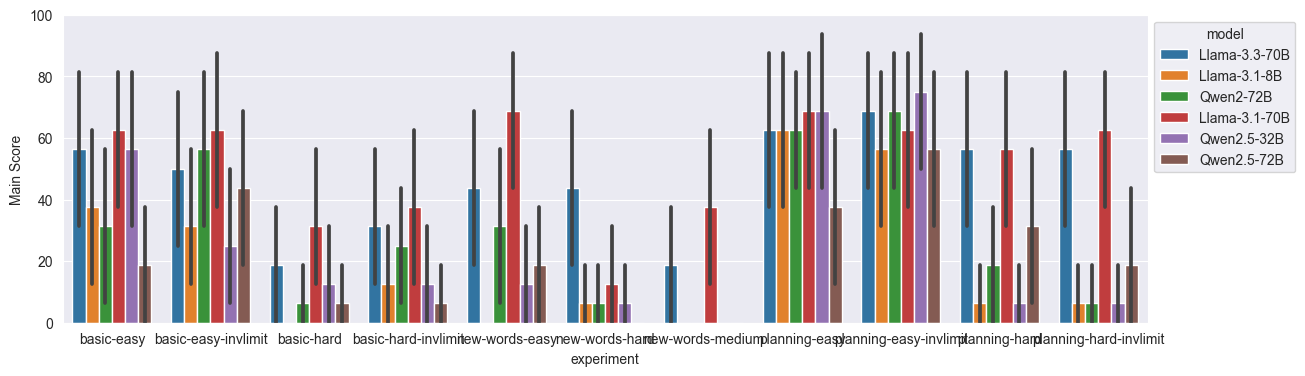

In [2755]:
metric_bar_plot(game_df, "Main Score", max_value=100)

Planning:

C:\Users\JJ\AppData\Local\Temp\ipykernel_20840\8844963.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  metric_df = source_df[game_df.metric == metric].sort_values('experiment')


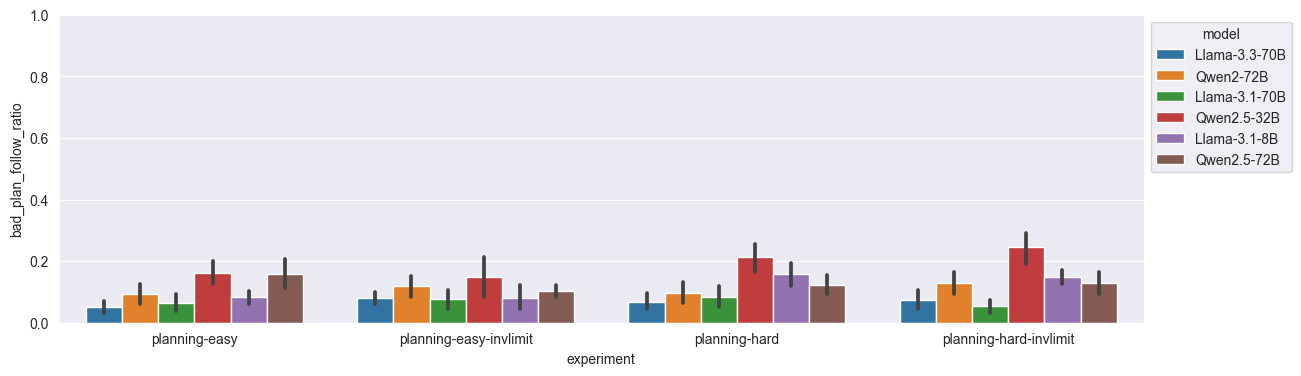

In [2756]:
metric_bar_plot(plan_df, "bad_plan_follow_ratio")

C:\Users\JJ\AppData\Local\Temp\ipykernel_20840\8844963.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  metric_df = source_df[game_df.metric == metric].sort_values('experiment')


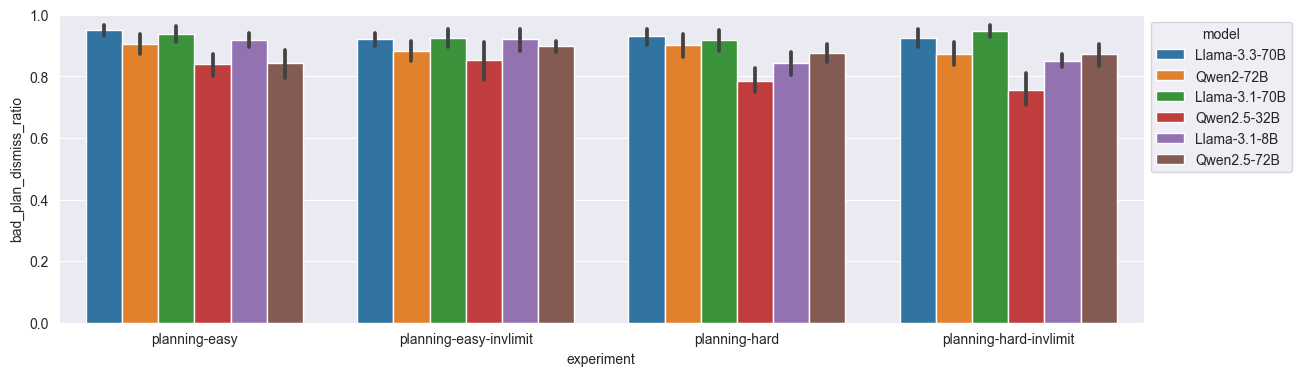

In [2757]:
metric_bar_plot(plan_df, "bad_plan_dismiss_ratio")

C:\Users\JJ\AppData\Local\Temp\ipykernel_20840\8844963.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  metric_df = source_df[game_df.metric == metric].sort_values('experiment')


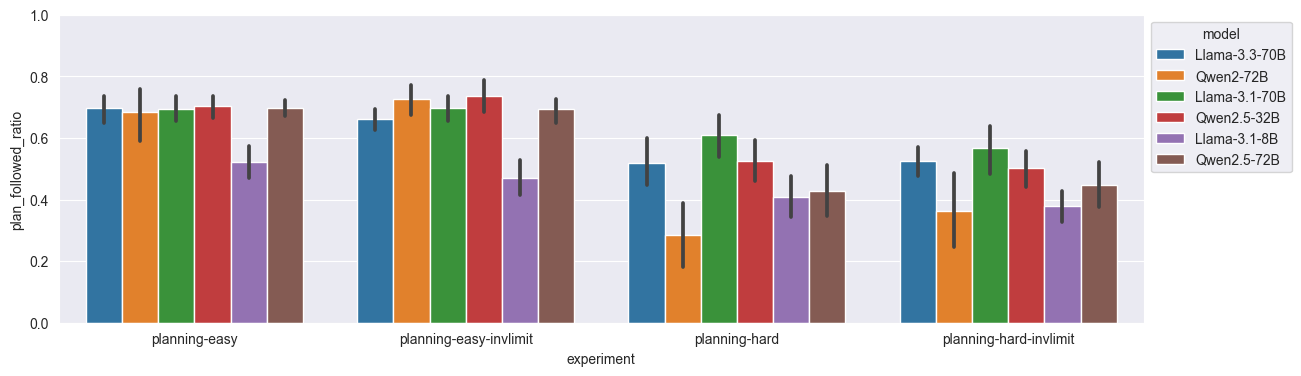

In [2758]:
metric_bar_plot(plan_df, "plan_followed_ratio")

C:\Users\JJ\AppData\Local\Temp\ipykernel_20840\8844963.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  metric_df = source_df[game_df.metric == metric].sort_values('experiment')


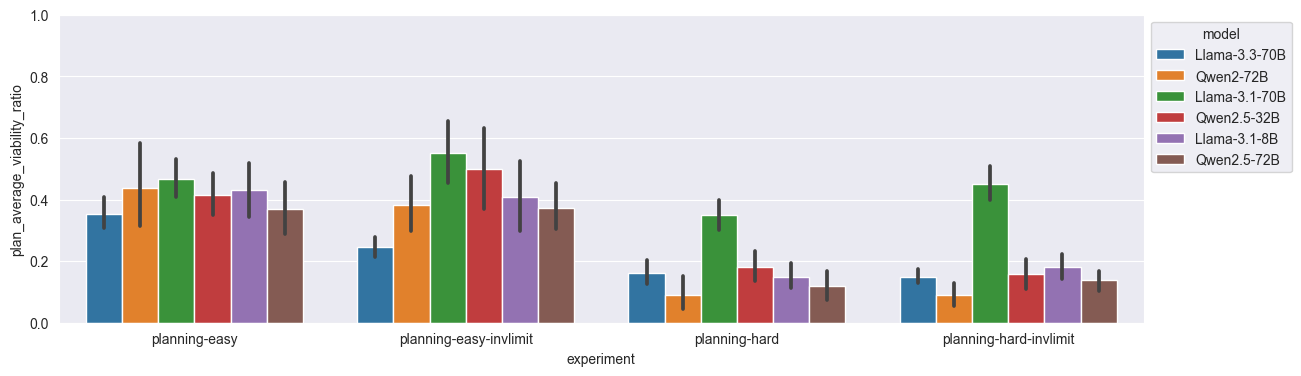

In [2759]:
metric_bar_plot(plan_df, "plan_average_viability_ratio")

# Aborted episodes stacked bars

In [2760]:
abort_metrics_turn = ["command_tag_missing", "next_actions_missing", "hallucination"]
abort_metrics_ep = ["turn_limit_loss"]

In [2761]:
def get_episode_abort_metrics(model_id: str, variant: str, episode: str):
    abort_dict = {"turn_limit": 0, "command_tag_missing": 0, "next_actions_missing": 0, "hallucination": 0}
    # load episode scores from JSON:
    with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
        scores = json.load(scores_file)
    # check episode scores:
    ep_scores = scores['episode scores']
    if ep_scores["Aborted"] == 1:
        abort_dict["turn_limit"] = ep_scores["turn_limit_loss"]
    # check turn scores:
    turns_scores = scores['turn scores']
    for turn_scores in turns_scores.values():
        if turn_scores["command_tag_missing"] == 1:
            abort_dict["command_tag_missing"] = turn_scores["command_tag_missing"]
            if turn_scores["hallucination"] == 1:
                abort_dict["hallucination"] = turn_scores["hallucination"]
            break
        if turn_scores["next_actions_missing"] == 1:
            abort_dict["next_actions_missing"] = turn_scores["next_actions_missing"]
            break

    return abort_dict

In [2762]:
# model_id = "o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0"
# variant = "1_home_deliver_three_planning_easy"
# episode = "episode_3"
# episode = "episode_9"
# get_episode_abort_metrics(model_id, variant, episode)

In [2763]:
def get_abort_metrics(model_id: str, variants: list):
    episodes = [f"episode_{number}" for number in range(0,16)]
    overall_abort_dict = {"turn_limit": 0, "command_tag_missing": 0, "next_actions_missing": 0, "hallucination": 0}
    for variant in variants:
        for episode in episodes:
            cur_abort_dict = get_episode_abort_metrics(model_id, variant, episode)
            for key, val in cur_abort_dict.items():
                # print(key, val)
                overall_abort_dict[key] += val

    return overall_abort_dict

In [2764]:
variants = ["0_home_deliver_three_basic_easy", "1_home_deliver_three_planning_easy", "2_home_deliver_three_basic_easy_invlimittwo",
            "3_home_deliver_three_planning_easy_invlimittwo", "4_home_deliver_three_basic_hard", "5_home_deliver_three_planning_hard",
            "6_home_deliver_three_basic_hard_invlimittwo", "7_home_deliver_three_planning_hard_invlimittwo"]

# get_abort_metrics("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants)

In [2765]:
def get_model_set_abort_metrics(model_ids: list, variants: list):
    abort_totals = dict()
    for model_id in model_ids:
        overall_abort_dict = get_abort_metrics(model_id, variants)
        abort_totals[model_name_dict[model_id]] = overall_abort_dict

    return abort_totals

In [2766]:
all_models_all_abort = get_model_set_abort_metrics(final_models, variants)
all_models_all_abort

{'Llama-3.1-70B': {'turn_limit': 5,
  'command_tag_missing': 1,
  'next_actions_missing': 1,
  'hallucination': 0},
 'Llama-3.3-70B': {'turn_limit': 2,
  'command_tag_missing': 4,
  'next_actions_missing': 0,
  'hallucination': 1},
 'Qwen2.5-32B': {'turn_limit': 48,
  'command_tag_missing': 2,
  'next_actions_missing': 0,
  'hallucination': 0},
 'Qwen2-72B': {'turn_limit': 42,
  'command_tag_missing': 9,
  'next_actions_missing': 0,
  'hallucination': 5},
 'Qwen2.5-72B': {'turn_limit': 47,
  'command_tag_missing': 3,
  'next_actions_missing': 0,
  'hallucination': 3},
 'Llama-3.1-8B': {'turn_limit': 66,
  'command_tag_missing': 0,
  'next_actions_missing': 0,
  'hallucination': 0}}

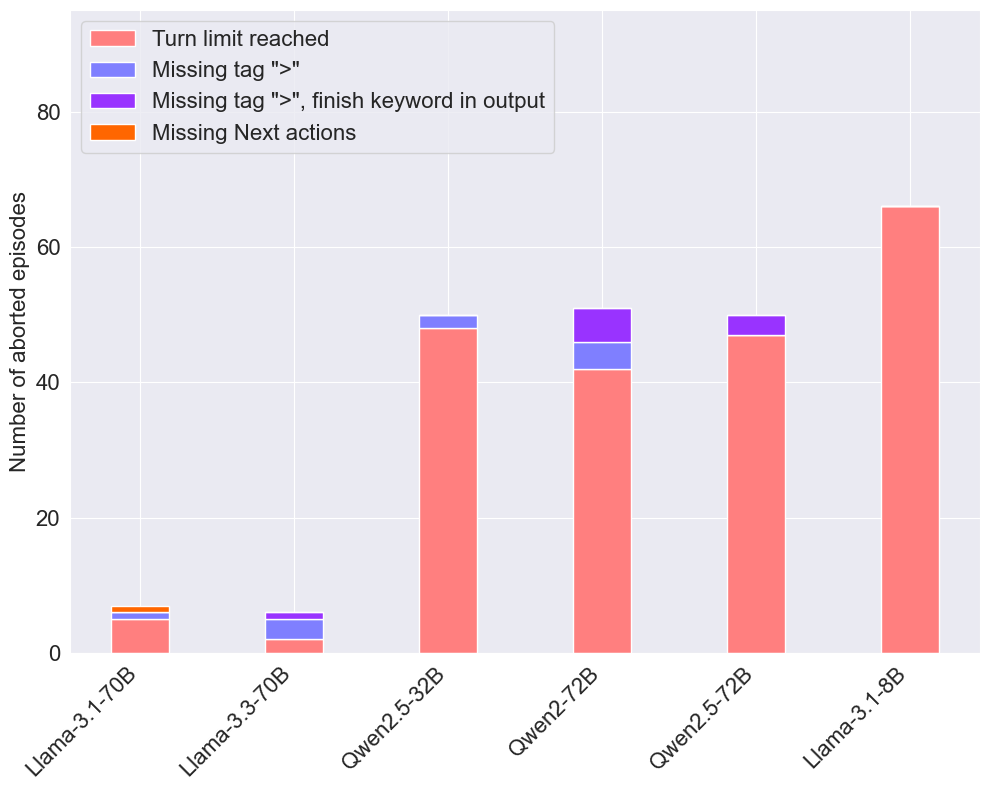

In [2767]:
abort_metrics_turn = ["command_tag_missing", "next_actions_missing", "hallucination"]
abort_metrics_ep = ["turn_limit_loss"]

# Prepare data for plotting
models = list()

turn_limit_losses = list()
command_tag_missings = list()
next_actions_missings = list()
hallucinations = list()

# opponent_faster_losses = []

for model_name, abort_data in all_models_all_abort.items():
    # Create shorter model name for display
    # short_name = model_name.split('-t0.0--')[0].split('-2024')[0].split('-2025')[0].replace('-Instruct', '').replace('-flash-exp', '').replace('-sonnet', '')
    models.append(model_name)

    # Get abort counts, default to 0 if not present
    turn_limit_losses.append(abort_data.get('turn_limit', 0))
    command_tag_missings.append(abort_data.get('command_tag_missing', 0))
    next_actions_missings.append(abort_data.get('next_actions_missing', 0))
    hallucinations.append(abort_data.get('hallucination', 0))

# print(models)

turn_limit_losses = np.array(turn_limit_losses)
command_tag_missings = np.array(command_tag_missings)
next_actions_missings = np.array(next_actions_missings)
hallucinations = np.array(hallucinations)

hallu_sub_tag_missings = command_tag_missings - hallucinations

# Set up the plot
plt.figure(figsize=(10, 8))

# Set the width of each bar and positions of the bars
width = 0.3
x = np.arange(len(models)) * 0.8  # Reduce spacing between bars

plt.ylim([0,95])

# Create the stacked bars
plt.bar(x, turn_limit_losses, width, label='Turn limit reached', color='#ff7f7f')
plt.bar(x, hallu_sub_tag_missings, width, bottom=turn_limit_losses, label='Missing tag ">"', color='#7f7fff')
plt.bar(x, hallucinations, width, bottom=hallu_sub_tag_missings + turn_limit_losses, label='Missing tag ">", finish keyword in output', color='#9933FF')
plt.bar(x, next_actions_missings, width, bottom=hallu_sub_tag_missings + turn_limit_losses + hallucinations, label='Missing Next actions', color='#FF6600')

# Customize the plot
plt.ylabel('Number of aborted episodes', fontsize=16)
# plt.title('Abort Distribution by Model', fontsize=16)
plt.xticks(x, models, rotation=45, ha='right', fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16, loc='upper left')
# plt.grid(True, linestyle='--', alpha=0.7, axis='y')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save the plot
plt.savefig('results/aborts_distribution.pdf', dpi=300, bbox_inches='tight')

# plt.close()
plt.show()

## Exploration

In [2768]:
# get single episode for exploration line plot
model_id = "Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0"
variant = "0_home_deliver_three_basic_easy"
episode = "episode_0"
with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
    scores = json.load(scores_file)
turn_scores = scores['turn scores']
turns_known_entities_ratio = [score_values['known_entities_ratio'] for score_values in turn_scores.values()]
turns_known_entities_ratio

[0.13793103448275862,
 0.13793103448275862,
 0.13793103448275862,
 0.1724137931034483,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552]

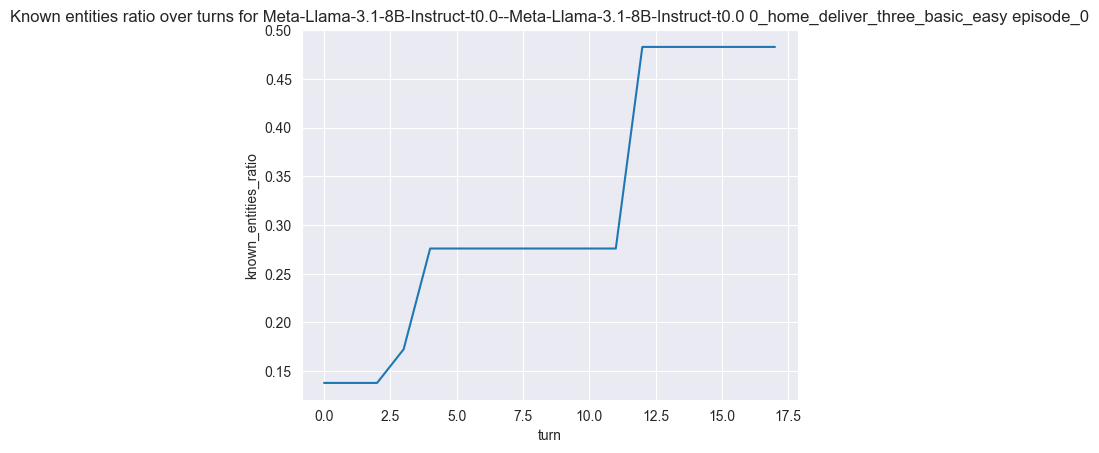

In [2769]:
fig, ax = plt.subplots()
ax.plot(turns_known_entities_ratio)

ax.set(xlabel='turn', ylabel='known_entities_ratio',
       title=f'Known entities ratio over turns for {model_id} {variant} {episode}')
# ax.grid()

# fig.savefig("test.png")
plt.show()

In [2770]:
# get single episode for exploration line plot
model_id = "Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0"
variant = "1_home_deliver_three_planning_easy"
episode = "episode_0"
with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
    scores = json.load(scores_file)
turn_scores = scores['turn scores']
turns_plan_command_success_ratio = [score_values['plan_command_success_ratio'] for score_values in turn_scores.values()]
turns_known_entities_ratio = [score_values['known_entities_ratio'] for score_values in turn_scores.values()]
turns_known_goal_entities_ratio = [score_values['known_goal_entities_ratio'] for score_values in turn_scores.values()]
turns_plan_command_success_ratio

[0.5,
 0.0,
 1.0,
 1.0,
 0.5,
 0.0,
 0.0,
 0.0,
 0.6,
 0.5,
 0.3333333333333333,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

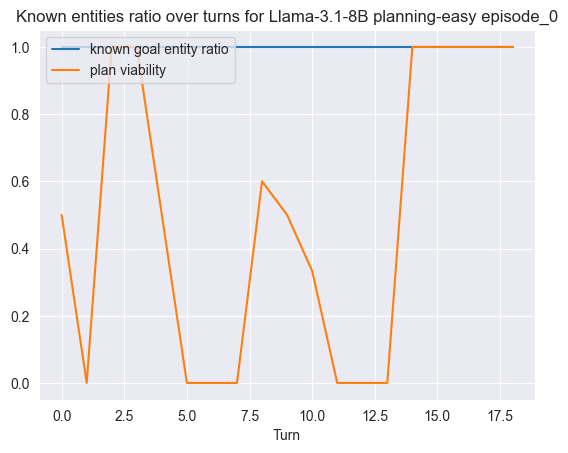

In [2771]:
fig, ax = plt.subplots()

# ax.plot(turns_known_entities_ratio)
ax.plot(turns_known_goal_entities_ratio)
ax.plot(turns_plan_command_success_ratio)

ax.set(xlabel='Turn',
       title=f'Known entities ratio over turns for {model_name_dict[model_id]} {experiment_short_name_dict[variant]} {episode}')
# ax.grid()
ax.legend(['known goal entity ratio', 'plan viability'], loc='upper left')

# fig.savefig("test.png")
plt.show()

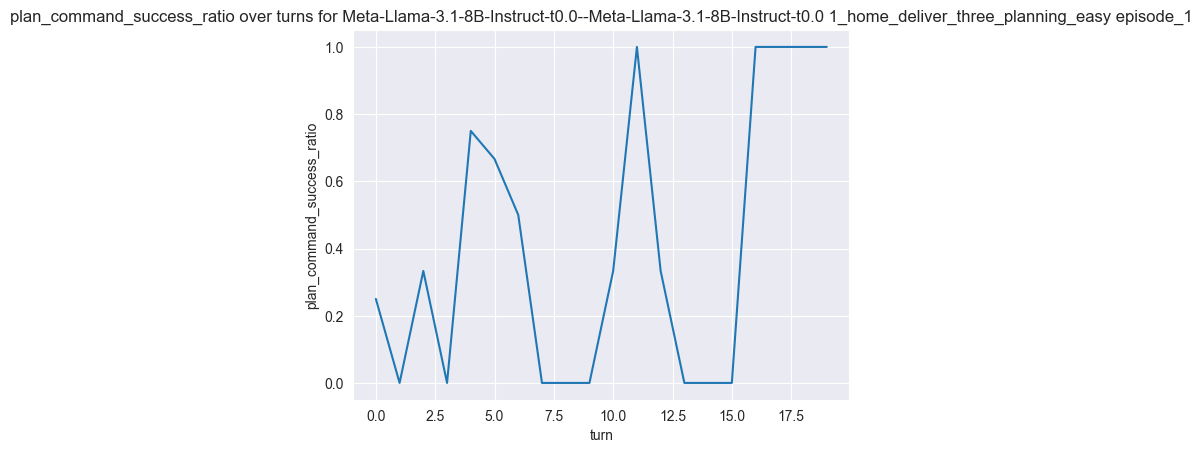

In [2772]:
model_id = "Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0"
variant = "1_home_deliver_three_planning_easy"
episode = "episode_1"
with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
    scores = json.load(scores_file)
turn_scores = scores['turn scores']
turns_plan_command_success_ratio = [score_values['plan_command_success_ratio'] for score_values in turn_scores.values()]
# turns_plan_command_success_ratio

fig, ax = plt.subplots()

# ax.plot(turns_known_entities_ratio)
ax.plot(turns_plan_command_success_ratio)

ax.set(xlabel='turn', ylabel='plan_command_success_ratio',
       title=f'plan_command_success_ratio over turns for {model_id} {variant} {episode}')
# ax.grid()

# fig.savefig("test.png")
plt.show()

In [2773]:
def get_score_progress_list(model_id: str, variant: str, episode: str, score: str):
    with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
        scores = json.load(scores_file)
    turn_scores = scores['turn scores']
    turns_score = [score_values[score] for score_values in turn_scores.values()]
    return turns_score

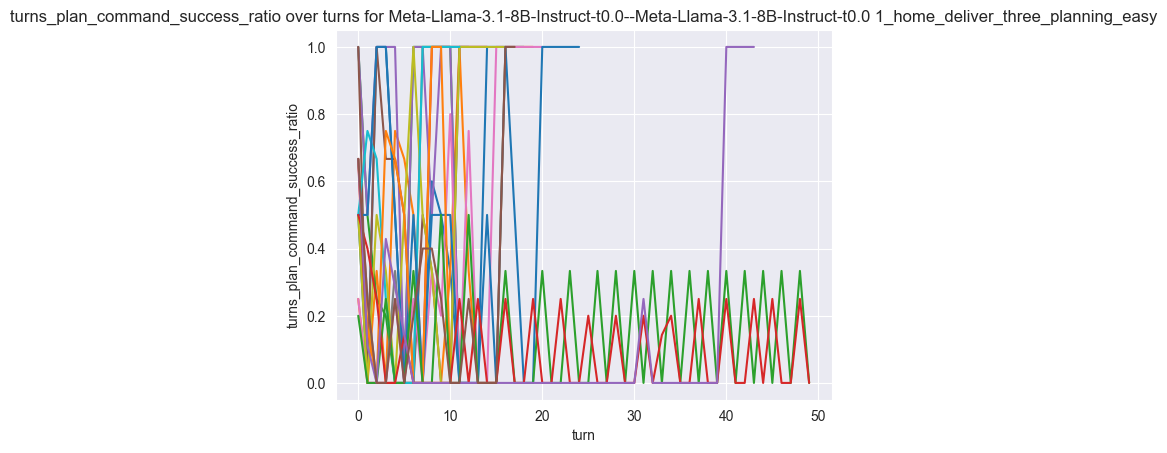

In [2774]:
model_id = "Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0"
# model_id = "openchat_3.5-GGUF-q8-t0.0--openchat_3.5-GGUF-q8-t0.0"
variant = "1_home_deliver_three_planning_easy"
episodes = [f"episode_{number}" for number in range(0,16)]

fig, ax = plt.subplots()

for episode in episodes:
    turns_plan_command_success_ratio = get_score_progress_list(model_id, variant, episode, "plan_command_success_ratio")
    ax.plot(turns_plan_command_success_ratio)

ax.set(xlabel='turn', ylabel='turns_plan_command_success_ratio',
       title=f'turns_plan_command_success_ratio over turns for {model_id} {variant}')
# ax.grid()

# fig.savefig("test.png")
plt.show()

In [2775]:
model_id = "Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0"
variant = "0_home_deliver_three_basic_easy"
episodes = [f"episode_{number}" for number in range(0,16)]

def get_exploration_progress_list(model_id: str, variant: str, episode: str, exploration_score: str):
    with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
        scores = json.load(scores_file)
    turn_scores = scores['turn scores']
    turns_exploration_score = [score_values[exploration_score] for score_values in turn_scores.values()]
    return turns_exploration_score

get_exploration_progress_list(model_id, variant, episodes[0], "known_entities_ratio")

[0.13793103448275862,
 0.13793103448275862,
 0.13793103448275862,
 0.1724137931034483,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552]

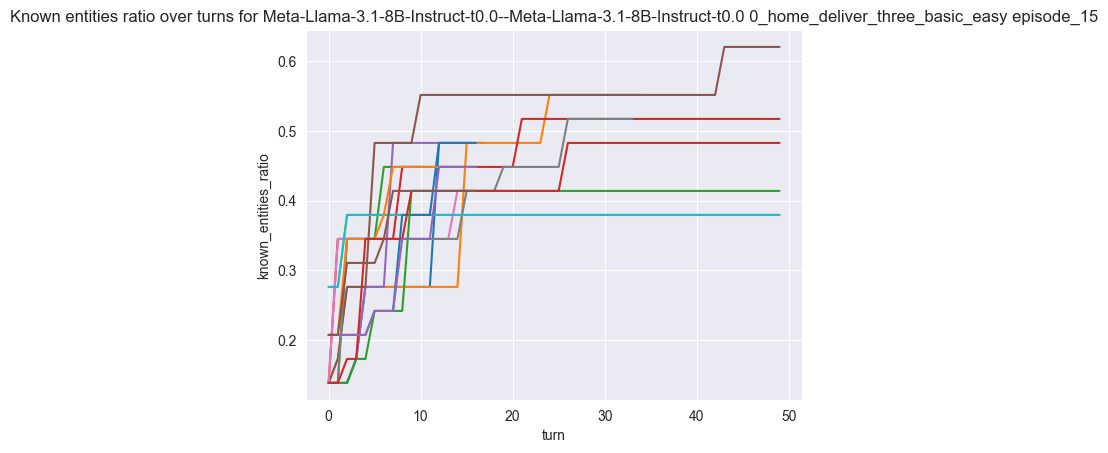

In [2776]:
fig, ax = plt.subplots()

for episode in episodes:
    turns_known_entities_ratio = get_exploration_progress_list(model_id, variant, episode, "known_entities_ratio")
    ax.plot(turns_known_entities_ratio)

ax.set(xlabel='turn', ylabel='known_entities_ratio',
       title=f'Known entities ratio over turns for {model_id} {variant} {episode}')
# ax.grid()

# fig.savefig("test.png")
plt.show()

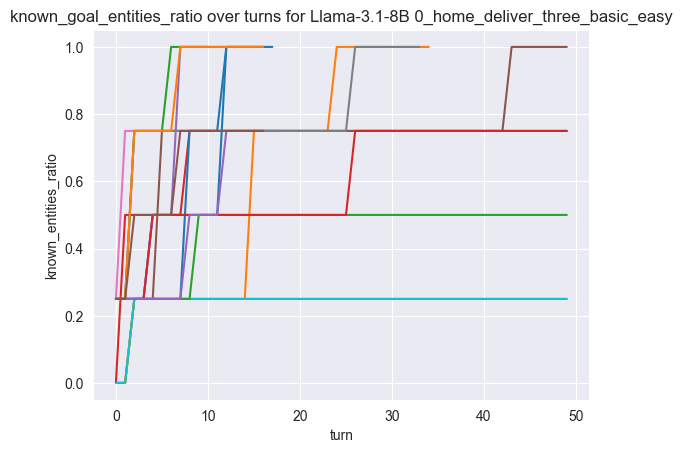

In [2777]:
exploration_score = "known_goal_entities_ratio"

fig, ax = plt.subplots()

for episode in episodes:
    turns_known_entities_ratio = get_exploration_progress_list(model_id, variant, episode, exploration_score)
    ax.plot(turns_known_entities_ratio)

ax.set(xlabel='turn', ylabel='known_entities_ratio',
       title=f'{exploration_score} over turns for {model_name_dict[model_id]} {variant}')
# ax.grid()

# fig.savefig("test.png")
plt.show()

In [2778]:
def get_exploration_progress_list(model_id: str, variant: str, episode: str, exploration_score: str):
    with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
        scores = json.load(scores_file)
    turn_scores = scores['turn scores']
    turns_exploration_score = [score_values[exploration_score] for score_values in turn_scores.values()]
    return turns_exploration_score

In [2779]:
# get episodes/plan viability progression for one model
model_id = "Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0"
variant = "1_home_deliver_three_planning_easy"
episodes = [f"episode_{number}" for number in range(0,16)]

list_of_progress_lists = list()

for episode in episodes:
    plan_viability_progress_list = get_exploration_progress_list(model_id, variant, episode, "plan_command_success_ratio")
    list_of_progress_lists.append(plan_viability_progress_list)

last_ten = [ep_list[-10:] for ep_list in list_of_progress_lists]

avg_last_ten_0 = list()

for turn_idx in range(10):
    turn_sum = sum([turn[turn_idx] for turn in last_ten])
    avg_last_ten_0.append(turn_sum / 16)

avg_last_ten_0


[0.29270833333333335,
 0.375,
 0.14583333333333334,
 0.25520833333333337,
 0.4114583333333333,
 0.546875,
 0.8333333333333334,
 0.8125,
 0.7239583333333334,
 0.6875]

In [2780]:
# get episodes/plan viability progression for one model
model_id = "Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0"
variant = "1_home_deliver_three_planning_easy"
episodes = [f"episode_{number}" for number in range(0,16)]

list_of_progress_lists = list()

for episode in episodes:
    plan_viability_progress_list = get_exploration_progress_list(model_id, variant, episode, "plan_command_success_ratio")
    list_of_progress_lists.append(plan_viability_progress_list)

last_ten = [ep_list[-10:] for ep_list in list_of_progress_lists]

avg_last_ten_1 = list()

for turn_idx in range(10):
    turn_sum = sum([turn[turn_idx] for turn in last_ten])
    avg_last_ten_1.append(turn_sum / 16)

avg_last_ten_1


[0.3282738095238095,
 0.2449404761904762,
 0.29756944444444444,
 0.4375,
 0.36458333333333326,
 0.44791666666666663,
 0.8214285714285714,
 0.9375,
 0.8125,
 0.006944444444444444]

In [2781]:
# get episodes/plan viability progression for one model
# model_id = "o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0"
model_id = "Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0"
variant = "1_home_deliver_three_planning_easy"
episodes = [f"episode_{number}" for number in range(0,16)]

list_of_progress_lists = list()

ep_count = 0

for episode in episodes:
    plan_viability_progress_list = get_exploration_progress_list(model_id, variant, episode, "plan_command_success_ratio")
    if len(plan_viability_progress_list) >= 10:
        list_of_progress_lists.append(plan_viability_progress_list)
        ep_count += 1

# print(ep_count)

last_ten = [ep_list[-10:] for ep_list in list_of_progress_lists]

avg_last_ten_2 = list()

for turn_idx in range(10):
    turn_sum = sum([turn[turn_idx] for turn in last_ten])
    avg_last_ten_2.append(turn_sum / ep_count)

avg_last_ten_2

[0.3282738095238095,
 0.2449404761904762,
 0.29756944444444444,
 0.4375,
 0.36458333333333326,
 0.44791666666666663,
 0.8214285714285714,
 0.9375,
 0.8125,
 0.006944444444444444]

## Over all turns

In [2782]:
def get_score_progress_list(model_id: str, variant: str, episode: str, score: str):
    with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
        scores = json.load(scores_file)
    turn_scores = scores['turn scores']
    turns_score = list()
    for turn_idx, turn_scores_value in enumerate(turn_scores.values()):
        if score in turn_scores_value:
            turns_score.append(turn_scores_value[score])
        else:
            print(f"{score} not in turn {turn_idx} of {model_id} {variant} {episode}")
            turns_score.append(np.nan)

    return turns_score

In [2783]:
# get_score_progress_list("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", "1_home_deliver_three_planning_easy", "episode_3", "known_entities_ratio")

In [2784]:
def get_avg_turns_score(model_id: str, variants: list, score: str):
    episodes = [f"episode_{number}" for number in range(0,16)]
    list_of_arrays = list()
    for variant in variants:
        for episode in episodes:
            score_progress_list = get_score_progress_list(model_id, variant, episode, score)
            prog_array = np.full(50, np.nan)
            for idx, val in enumerate(score_progress_list):
                prog_array[idx] = val
            list_of_arrays.append(prog_array)

    progress_array = np.array(list_of_arrays)
    averages_array = np.nanmean(progress_array, axis=0)

    return averages_array

In [2785]:
variants = ["1_home_deliver_three_planning_easy", "3_home_deliver_three_planning_easy_invlimittwo",
           "5_home_deliver_three_planning_hard", "7_home_deliver_three_planning_hard_invlimittwo"]

# variants = ["1_home_deliver_three_planning_easy"]

# get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, "plan_command_success_ratio")

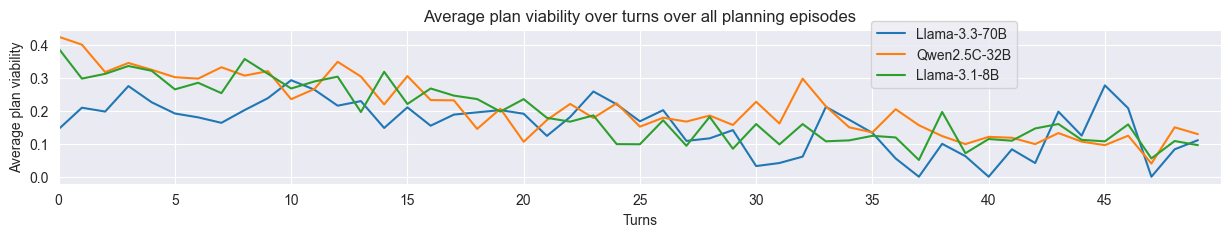

In [2786]:
variants = ["1_home_deliver_three_planning_easy", "3_home_deliver_three_planning_easy_invlimittwo",
           "5_home_deliver_three_planning_hard", "7_home_deliver_three_planning_hard_invlimittwo"]

fig, ax = plt.subplots(figsize=(15, 2))

# ax.plot(get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, "plan_command_success_ratio"), label="o3-mini")
# ax.plot(get_avg_turns_score("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, "plan_command_success_ratio"), label="Claude3.5")
ax.plot(get_avg_turns_score("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, "plan_command_success_ratio"), label="Llama-3.3-70B")
ax.plot(get_avg_turns_score("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, "plan_command_success_ratio"), label="Qwen2.5C-32B")
ax.plot(get_avg_turns_score("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants, "plan_command_success_ratio"), label="Llama-3.1-8B")

ax.set(xlabel='Turns', ylabel='Average plan viability',
       title=f'Average plan viability over turns over all planning episodes'
       )
# ax.grid()

plt.xlim([0,50])
plt.xticks(np.arange(0, 50, step=5))

# plt.ylim([0,0.3])
# plt.yticks(np.arange(0, 0.25, step=0.2))


plt.legend(bbox_to_anchor=(0.83, 1.1), loc="upper right")


# fig.savefig("results/top_models_plan_viability_all.pdf", format="pdf", bbox_inches="tight")
fig.savefig("results/comp_models_plan_viability_all.pdf", format="pdf", bbox_inches="tight")
# fig.savefig("results/top_models_plan_viability_all.png")
fig.savefig("results/comp_models_plan_viability_all.png")

plt.show()

C:\Users\JJ\AppData\Local\Temp\ipykernel_20840\3033359787.py:13: RuntimeWarning: Mean of empty slice
  averages_array = np.nanmean(progress_array, axis=0)


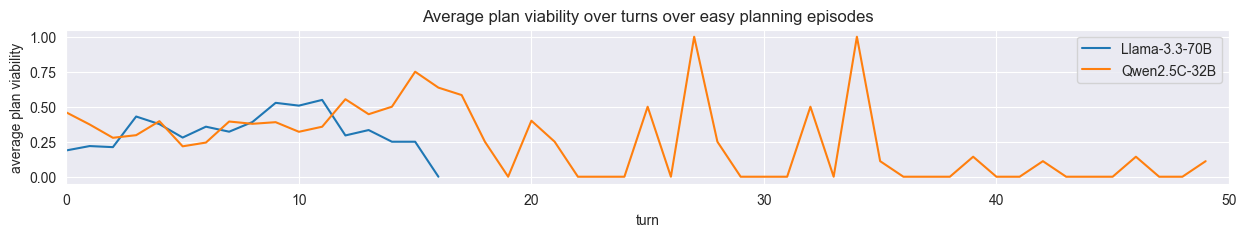

In [2787]:
variants = ["1_home_deliver_three_planning_easy"]

fig, ax = plt.subplots(figsize=(15, 2))

# ax.plot(get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, "plan_command_success_ratio"), label="o3-mini")
# ax.plot(get_avg_turns_score("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, "plan_command_success_ratio"), label="Claude3.5")
ax.plot(get_avg_turns_score("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, "plan_command_success_ratio"), label="Llama-3.3-70B")
ax.plot(get_avg_turns_score("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, "plan_command_success_ratio"), label="Qwen2.5C-32B")

ax.set(xlabel='turn', ylabel='average plan viability',
       title=f'Average plan viability over turns over easy planning episodes')
# ax.grid()

plt.xlim([0,50])

plt.legend()

fig.savefig("results/top_models_plan_viability_easy.pdf", format="pdf", bbox_inches="tight")
fig.savefig("results/top_models_plan_viability_easy.png")

plt.show()

C:\Users\JJ\AppData\Local\Temp\ipykernel_20840\3033359787.py:13: RuntimeWarning: Mean of empty slice
  averages_array = np.nanmean(progress_array, axis=0)


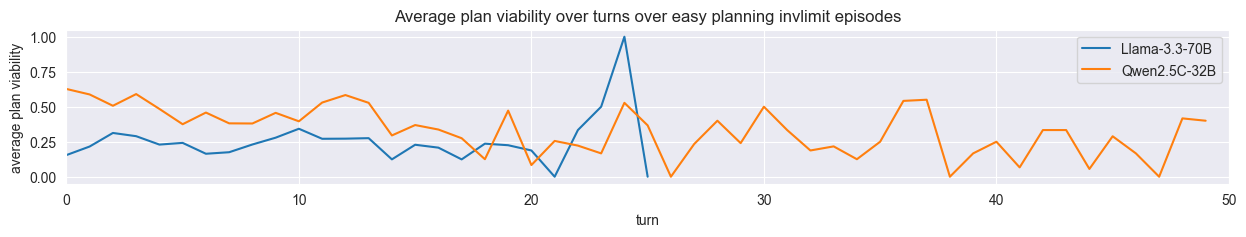

In [2788]:
variants = ["3_home_deliver_three_planning_easy_invlimittwo"]

fig, ax = plt.subplots(figsize=(15, 2))

# ax.plot(get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, "plan_command_success_ratio"), label="o3-mini")
# ax.plot(get_avg_turns_score("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, "plan_command_success_ratio"), label="Claude3.5")
ax.plot(get_avg_turns_score("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, "plan_command_success_ratio"), label="Llama-3.3-70B")
ax.plot(get_avg_turns_score("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, "plan_command_success_ratio"), label="Qwen2.5C-32B")

ax.set(xlabel='turn', ylabel='average plan viability',
       title=f'Average plan viability over turns over easy planning invlimit episodes')
# ax.grid()

plt.xlim([0,50])

plt.legend()

fig.savefig("results/top_models_plan_viability_easy_invlimit.pdf", format="pdf", bbox_inches="tight")
fig.savefig("results/top_models_plan_viability_easy_invlimit.png")

plt.show()

C:\Users\JJ\AppData\Local\Temp\ipykernel_20840\3033359787.py:13: RuntimeWarning: Mean of empty slice
  averages_array = np.nanmean(progress_array, axis=0)


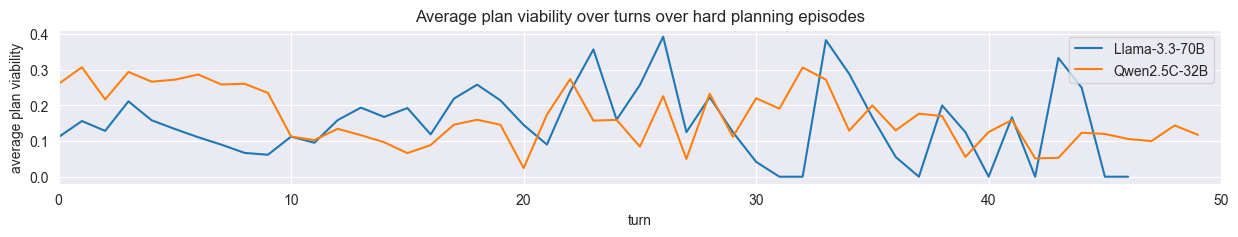

In [2789]:
variants = ["5_home_deliver_three_planning_hard"]

fig, ax = plt.subplots(figsize=(15, 2))

# ax.plot(get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, "plan_command_success_ratio"), label="o3-mini")
# ax.plot(get_avg_turns_score("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, "plan_command_success_ratio"), label="Claude3.5")
ax.plot(get_avg_turns_score("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, "plan_command_success_ratio"), label="Llama-3.3-70B")
ax.plot(get_avg_turns_score("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, "plan_command_success_ratio"), label="Qwen2.5C-32B")

ax.set(xlabel='turn', ylabel='average plan viability',
       title=f'Average plan viability over turns over hard planning episodes')
# ax.grid()

plt.xlim([0,50])

plt.legend()

fig.savefig("results/top_models_plan_viability_hard.pdf", format="pdf", bbox_inches="tight")
fig.savefig("results/top_models_plan_viability_hard.png")

plt.show()

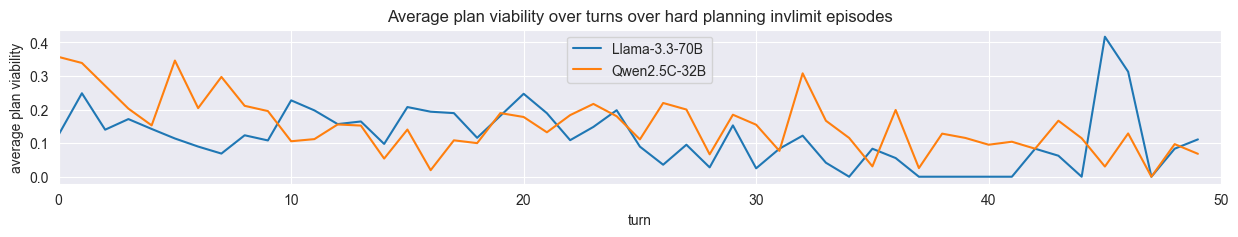

In [2790]:
variants = ["7_home_deliver_three_planning_hard_invlimittwo"]

fig, ax = plt.subplots(figsize=(15, 2))

# ax.plot(get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, "plan_command_success_ratio"), label="o3-mini")
# ax.plot(get_avg_turns_score("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, "plan_command_success_ratio"), label="Claude3.5")
ax.plot(get_avg_turns_score("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, "plan_command_success_ratio"), label="Llama-3.3-70B")
ax.plot(get_avg_turns_score("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, "plan_command_success_ratio"), label="Qwen2.5C-32B")

ax.set(xlabel='turn', ylabel='average plan viability',
       title=f'Average plan viability over turns over hard planning invlimit episodes')
# ax.grid()

plt.xlim([0,50])

plt.legend()

fig.savefig("results/top_models_plan_viability_hard_invlimit.pdf", format="pdf", bbox_inches="tight")
fig.savefig("results/top_models_plan_viability_hard_invlimit.png")

plt.show()

#### Combined plan viability + plan following

In [2791]:
def get_viab_follow_progress_list(model_id: str, variant: str, episode: str):
    with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
        scores = json.load(scores_file)
    turn_scores = scores['turn scores']
    turns_score = list()

    # print(turn_scores)

    for turn_idx, turn_scores_value in enumerate(turn_scores.values()):

        # print(turn_scores.values())

        success_ratio_found = False
        plan_follow_found = False
        plan_compound = np.nan

        if turn_idx < 1:
            continue

        if "plan_command_success_ratio" in turn_scores_value:
            success_ratio_found = True
            # turns_score.append(turn_scores_value[score])
        else:
            print(f"plan_command_success_ratio not in turn {turn_idx} of {model_id} {variant} {episode}")
            # turns_score.append(np.nan)

        print(f"looking at turn {str(turn_idx+1)}:")

        if str(turn_idx+1) in turn_scores:
            print(f"turn {str(turn_idx+1)} is in turn_scores")
            # if "plan_followed" in turn_scores[str(turn_idx+1)].values():
            if "plan_followed" in turn_scores[str(turn_idx+1)]:
                plan_follow_found = True
            else:
                print(f"plan_followed not in turn {turn_idx+1} of {model_id} {variant} {episode}")
        else:
            print(f"no turn {turn_idx+1} in {model_id} {variant} {episode}")

        if success_ratio_found and plan_follow_found:
            print(f"following plan followed there, calulcating compound!")
            # plan_compound = turn_scores_value["plan_command_success_ratio"] + turn_scores[str(turn_idx+1)].values()["plan_followed"]
            plan_compound = turn_scores_value["plan_command_success_ratio"] + turn_scores[str(turn_idx+1)]["plan_followed"]
        else:
            print(f"following plan followed not found!")

        turns_score.append(plan_compound)

    return turns_score

In [2792]:
# get_viab_follow_progress_list("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", "1_home_deliver_three_planning_easy", "episode_0")

In [2793]:
def get_avg_plan_compound(model_id: str, variants: list):
    episodes = [f"episode_{number}" for number in range(0,16)]
    list_of_arrays = list()
    for variant in variants:
        for episode in episodes:
            score_progress_list = get_viab_follow_progress_list(model_id, variant, episode)
            prog_array = np.full(50, np.nan)
            for idx, val in enumerate(score_progress_list):
                prog_array[idx] = val
            list_of_arrays.append(prog_array)

    progress_array = np.array(list_of_arrays)
    averages_array = np.nanmean(progress_array, axis=0)

    return averages_array

### Last ten turns

In [2794]:
def get_avg_last_turns_score(model_id: str, variants: list, score: str, n_turns: int):
    episodes = [f"episode_{number}" for number in range(0,16)]
    list_of_progress_lists = list()
    ep_count = 0
    for variant in variants:
        for episode in episodes:
            plan_viability_progress_list = get_score_progress_list(model_id, variant, episode, score)
            if len(plan_viability_progress_list) >= n_turns:
                list_of_progress_lists.append(plan_viability_progress_list)
                ep_count += 1
    print(f"{ep_count} viable episodes for {model_id}")
    last_n = [ep_list[-n_turns:] for ep_list in list_of_progress_lists]
    avg_last_n = list()
    for turn_idx in range(n_turns):
        turn_sum = sum([turn[turn_idx] for turn in last_n])
        avg_last_n.append(turn_sum / ep_count)

    return avg_last_n

In [2795]:
variants = ["1_home_deliver_three_planning_easy", "3_home_deliver_three_planning_easy_invlimittwo",
            "5_home_deliver_three_planning_hard", "7_home_deliver_three_planning_hard_invlimittwo"]

# get_avg_last_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, "plan_command_success_ratio", 10)

62 viable episodes for Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0
63 viable episodes for Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0
63 viable episodes for Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0


C:\Users\JJ\AppData\Local\Temp\ipykernel_20840\3929884120.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(reverse_turns)


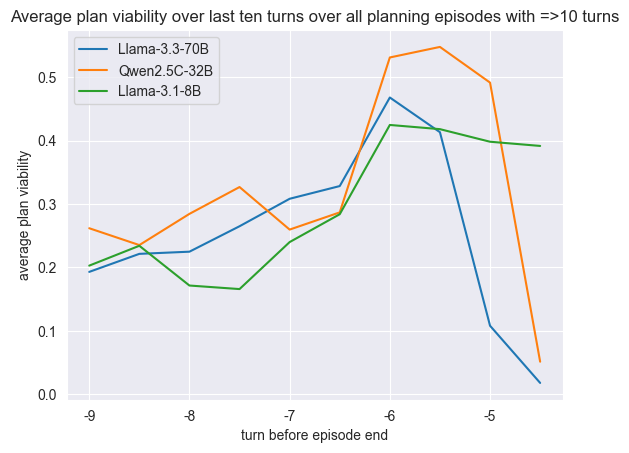

In [2796]:
fig, ax = plt.subplots()

# ax.plot(get_avg_last_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, "plan_command_success_ratio", 10), label="o3-mini")
# ax.plot(get_avg_last_turns_score("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, "plan_command_success_ratio", 10), label="Claude3.5")
ax.plot(get_avg_last_turns_score("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, "plan_command_success_ratio", 10), label="Llama-3.3-70B")
ax.plot(get_avg_last_turns_score("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, "plan_command_success_ratio", 10), label="Qwen2.5C-32B")
ax.plot(get_avg_last_turns_score("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants, "plan_command_success_ratio", 10), label="Llama-3.1-8B")

ax.set(xlabel='turn before episode end', ylabel='average plan viability',
       title=f'Average plan viability over last ten turns over all planning episodes with =>10 turns')
# ax.grid()

reverse_turns = ["-10", "-9", "-8", "-7", "-6", "-5", "-4", "-3", "-2", "-1"]

# ax.set_ticks(reverse_turns)

ax.set_xticklabels(reverse_turns)

plt.legend()

fig.savefig("results/plan_viability_last_ten_turns.pdf", format="pdf", bbox_inches="tight")

plt.show()

## Epistemic/Pragmatic

In [2797]:
# variants = ["1_home_deliver_three_planning_easy", "3_home_deliver_three_planning_easy_invlimittwo",
#           "5_home_deliver_three_planning_hard", "7_home_deliver_three_planning_hard_invlimittwo"]

# variants = ["0_home_deliver_three_basic_easy", "1_home_deliver_three_planning_easy", "2_home_deliver_three_basic_easy_invlimittwo",
#            "3_home_deliver_three_planning_easy_invlimittwo", "4_home_deliver_three_basic_hard", "5_home_deliver_three_planning_hard",
#            "6_home_deliver_three_basic_hard_invlimittwo", "7_home_deliver_three_planning_hard_invlimittwo"]

variants = ["1_home_deliver_three_planning_easy"]

# variants = ["0_home_deliver_three_basic_easy"]

# get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, "known_entities_ratio")

known_entities_ratio not in turn 15 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 1_home_deliver_three_planning_easy episode_11
known_entities_ratio not in turn 21 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 4_home_deliver_three_basic_hard episode_5
known_entities_ratio not in turn 44 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 5_home_deliver_three_planning_hard episode_10
known_entities_ratio not in turn 26 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 7_home_deliver_three_planning_hard_invlimittwo episode_14
known_entities_ratio not in turn 43 of Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0 5_home_deliver_three_planning_hard episode_6
known_entities_ratio not in turn 8 of Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0 7_home_deliver_three_planning_hard_invlimittwo episode_5


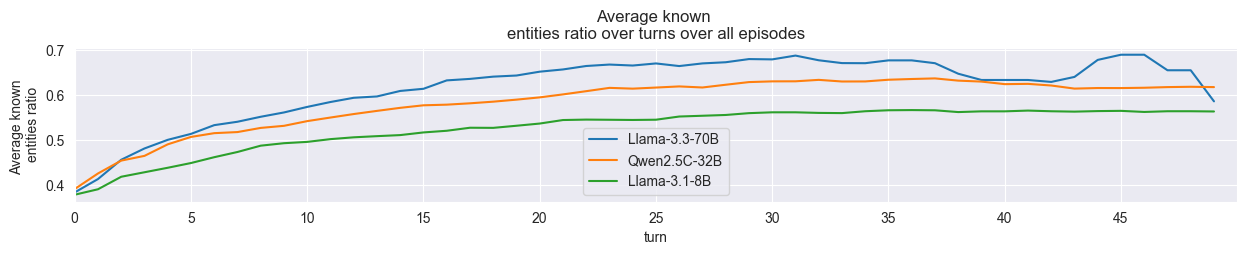

In [2798]:
variants = ["0_home_deliver_three_basic_easy", "1_home_deliver_three_planning_easy", "2_home_deliver_three_basic_easy_invlimittwo",
            "3_home_deliver_three_planning_easy_invlimittwo", "4_home_deliver_three_basic_hard", "5_home_deliver_three_planning_hard",
            "6_home_deliver_three_basic_hard_invlimittwo", "7_home_deliver_three_planning_hard_invlimittwo"]

fig, ax = plt.subplots(figsize=(15, 2))

# ax.plot(get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, "known_entities_ratio"), label="o3-mini")
# ax.plot(get_avg_turns_score("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, "known_entities_ratio"), label="Claude3.5")
ax.plot(get_avg_turns_score("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, "known_entities_ratio"), label="Llama-3.3-70B")
ax.plot(get_avg_turns_score("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, "known_entities_ratio"), label="Qwen2.5C-32B")
ax.plot(get_avg_turns_score("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants, "known_entities_ratio"), label="Llama-3.1-8B")

metric_name = "known \nentities ratio"

ax.set(xlabel='turn', ylabel=f'Average {metric_name}',
       title=f'Average {metric_name} over turns over all episodes')
# ax.grid()

plt.xlim([0,50])
plt.xticks(np.arange(0, 50, step=5))

# plt.ylim([0,0.3])
# plt.yticks(np.arange(0, 0.25, step=0.2))


# plt.legend(bbox_to_anchor=(0.83, 1.1), loc="upper right")
# plt.legend()
plt.legend(loc="lower center")

fig.savefig("results/top_models_known_entities_ratio_all.pdf", format="pdf", bbox_inches="tight")
fig.savefig("results/top_models_known_entities_ratio_all.png")

plt.show()

known_goal_entities_ratio not in turn 15 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 1_home_deliver_three_planning_easy episode_11
known_goal_entities_ratio not in turn 21 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 4_home_deliver_three_basic_hard episode_5
known_goal_entities_ratio not in turn 44 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 5_home_deliver_three_planning_hard episode_10
known_goal_entities_ratio not in turn 26 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 7_home_deliver_three_planning_hard_invlimittwo episode_14
known_goal_entities_ratio not in turn 43 of Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0 5_home_deliver_three_planning_hard episode_6
known_goal_entities_ratio not in turn 8 of Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0 7_home_deliver_three_planning_hard_invlimittwo episode_5


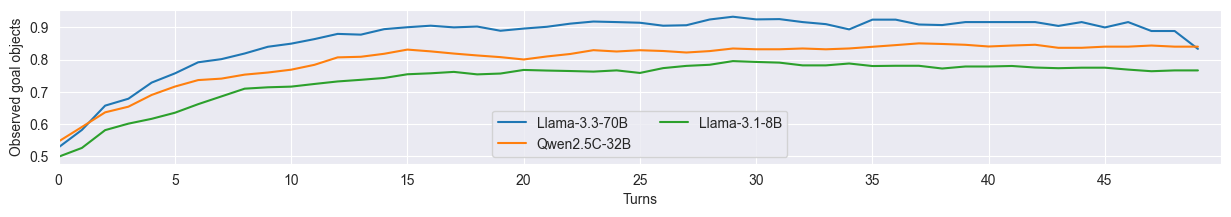

In [2799]:
variants = ["0_home_deliver_three_basic_easy", "1_home_deliver_three_planning_easy", "2_home_deliver_three_basic_easy_invlimittwo",
            "3_home_deliver_three_planning_easy_invlimittwo", "4_home_deliver_three_basic_hard", "5_home_deliver_three_planning_hard",
            "6_home_deliver_three_basic_hard_invlimittwo", "7_home_deliver_three_planning_hard_invlimittwo"]

fig, ax = plt.subplots(figsize=(15, 2))

metric = "known_goal_entities_ratio"

# ax.plot(get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, metric), label="o3-mini")
# ax.plot(get_avg_turns_score("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, metric), label="Claude3.5")
ax.plot(get_avg_turns_score("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, metric), label="Llama-3.3-70B")
ax.plot(get_avg_turns_score("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, metric), label="Qwen2.5C-32B")
ax.plot(get_avg_turns_score("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants, metric), label="Llama-3.1-8B")

metric_name = "Observed goal objects"

ax.set(xlabel='Turns', ylabel=f'{metric_name}',
       # title=f'Average {metric_name} over turns over all episodes'
       )
# ax.grid()

plt.xlim([0,50])
plt.xticks(np.arange(0, 50, step=5))

plt.legend(ncols=2, loc='lower center')

fig.savefig("results/known_goal_entities_ratio.pdf", format="pdf", bbox_inches="tight")
fig.savefig("results/known_goal_entities_ratio.png")

plt.show()

visited_rooms_ratio not in turn 15 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 1_home_deliver_three_planning_easy episode_11
visited_rooms_ratio not in turn 21 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 4_home_deliver_three_basic_hard episode_5
visited_rooms_ratio not in turn 44 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 5_home_deliver_three_planning_hard episode_10
visited_rooms_ratio not in turn 26 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 7_home_deliver_three_planning_hard_invlimittwo episode_14
visited_rooms_ratio not in turn 43 of Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0 5_home_deliver_three_planning_hard episode_6
visited_rooms_ratio not in turn 8 of Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0 7_home_deliver_three_planning_hard_invlimittwo episode_5


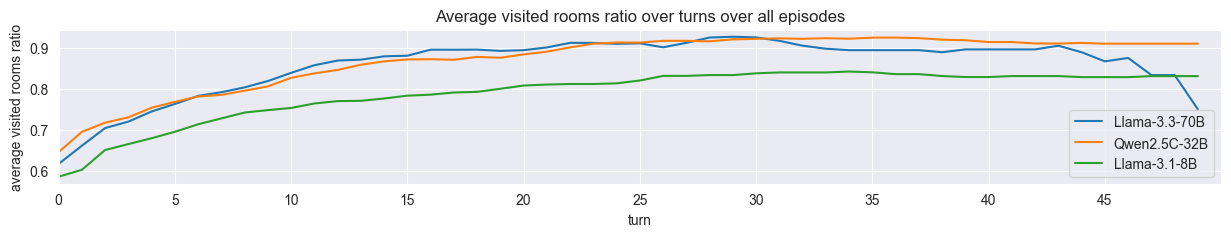

In [2800]:
variants = ["0_home_deliver_three_basic_easy", "1_home_deliver_three_planning_easy", "2_home_deliver_three_basic_easy_invlimittwo",
            "3_home_deliver_three_planning_easy_invlimittwo", "4_home_deliver_three_basic_hard", "5_home_deliver_three_planning_hard",
            "6_home_deliver_three_basic_hard_invlimittwo", "7_home_deliver_three_planning_hard_invlimittwo"]

fig, ax = plt.subplots(figsize=(15, 2))

metric = "visited_rooms_ratio"

# ax.plot(get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, metric), label="o3-mini")
# ax.plot(get_avg_turns_score("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, metric), label="Claude3.5")
ax.plot(get_avg_turns_score("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, metric), label="Llama-3.3-70B")
ax.plot(get_avg_turns_score("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, metric), label="Qwen2.5C-32B")
ax.plot(get_avg_turns_score("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants, metric), label="Llama-3.1-8B")

metric_name = "visited rooms ratio"

ax.set(xlabel='turn', ylabel=f'average {metric_name}',
       title=f'Average {metric_name} over turns over all episodes')
# ax.grid()

plt.xlim([0,50])
plt.xticks(np.arange(0, 50, step=5))

plt.legend()

fig.savefig("results/top_models_visited_rooms_ratio_all.pdf", format="pdf", bbox_inches="tight")
fig.savefig("results/top_models_visited_rooms_ratio_all.png")

plt.show()

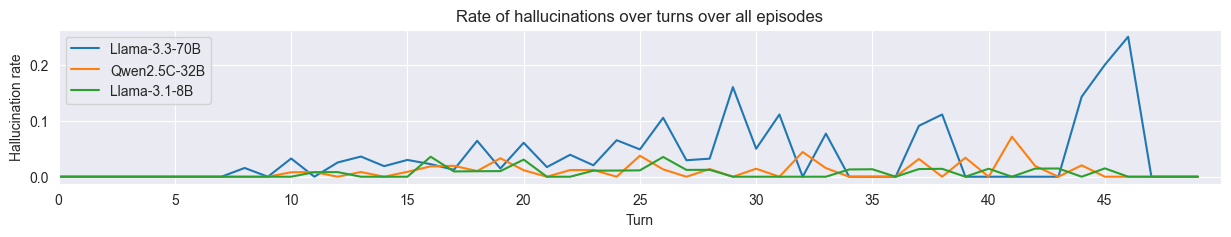

In [2801]:
variants = ["0_home_deliver_three_basic_easy", "1_home_deliver_three_planning_easy", "2_home_deliver_three_basic_easy_invlimittwo",
            "3_home_deliver_three_planning_easy_invlimittwo", "4_home_deliver_three_basic_hard", "5_home_deliver_three_planning_hard",
            "6_home_deliver_three_basic_hard_invlimittwo", "7_home_deliver_three_planning_hard_invlimittwo"]

fig, ax = plt.subplots(figsize=(15, 2))

metric = "hallucination"

# ax.plot(get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, metric), label="o3-mini")
# ax.plot(get_avg_turns_score("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, metric), label="Claude3.5")
ax.plot(get_avg_turns_score("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, metric), label="Llama-3.3-70B")
ax.plot(get_avg_turns_score("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, metric), label="Qwen2.5C-32B")
ax.plot(get_avg_turns_score("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants, metric), label="Llama-3.1-8B")

metric_name = "hallucinations"

ax.set(xlabel='Turn', ylabel=f'Hallucination rate',
       title=f'Rate of {metric_name} over turns over all episodes')
# ax.grid()

plt.xlim([0,50])
plt.xticks(np.arange(0, 50, step=5))

plt.legend()

fig.savefig("results/top_models_hallucinations_all.pdf", format="pdf", bbox_inches="tight")
fig.savefig("results/top_models_hallucinations_all.png")

plt.show()

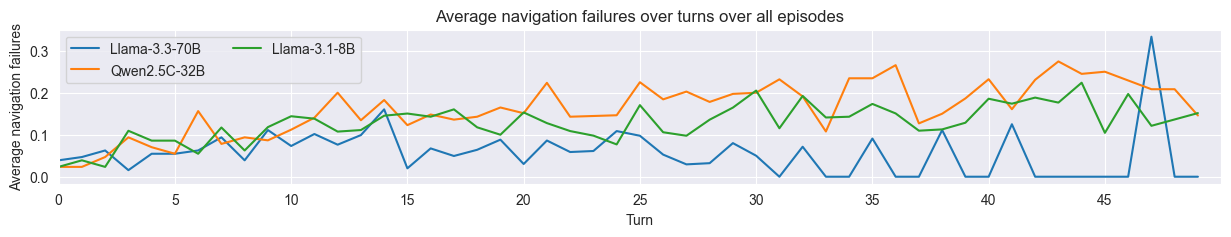

In [2802]:
variants = ["0_home_deliver_three_basic_easy", "1_home_deliver_three_planning_easy", "2_home_deliver_three_basic_easy_invlimittwo",
            "3_home_deliver_three_planning_easy_invlimittwo", "4_home_deliver_three_basic_hard", "5_home_deliver_three_planning_hard",
            "6_home_deliver_three_basic_hard_invlimittwo", "7_home_deliver_three_planning_hard_invlimittwo"]

fig, ax = plt.subplots(figsize=(15, 2))

metric = "no_exit_to"

# ax.plot(get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, metric), label="o3-mini")
# ax.plot(get_avg_turns_score("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, metric), label="Claude3.5")
ax.plot(get_avg_turns_score("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, metric), label="Llama-3.3-70B")
ax.plot(get_avg_turns_score("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, metric), label="Qwen2.5C-32B")
ax.plot(get_avg_turns_score("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants, metric), label="Llama-3.1-8B")

metric_name = "navigation failures"

ax.set(xlabel='Turn', ylabel=f'Average {metric_name}',
       title=f'Average {metric_name} over turns over all episodes')
# ax.grid()

plt.xlim([0,50])
plt.xticks(np.arange(0, 50, step=5))

plt.legend(ncols=2)

fig.savefig("results/top_models_nav_fail_all.pdf", format="pdf", bbox_inches="tight")
fig.savefig("results/top_models_nav_fail_all.png")

plt.show()

In [2803]:
def get_min_turns_score(model_id: str, variants: list, score: str):
    episodes = [f"episode_{number}" for number in range(0,16)]
    list_of_arrays = list()
    for variant in variants:
        for episode in episodes:
            score_progress_list = get_score_progress_list(model_id, variant, episode, score)
            prog_array = np.full(50, np.nan)
            for idx, val in enumerate(score_progress_list):
                prog_array[idx] = val
            list_of_arrays.append(prog_array)

    progress_array = np.array(list_of_arrays)
    min_array = np.nanmin(progress_array, axis=0)

    return min_array

In [2804]:
def get_median_turns_score(model_id: str, variants: list, score: str):
    episodes = [f"episode_{number}" for number in range(0,16)]
    list_of_arrays = list()
    for variant in variants:
        for episode in episodes:
            score_progress_list = get_score_progress_list(model_id, variant, episode, score)
            prog_array = np.full(50, np.nan)
            for idx, val in enumerate(score_progress_list):
                prog_array[idx] = val
            list_of_arrays.append(prog_array)

    progress_array = np.array(list_of_arrays)
    median_array = np.nanmedian(progress_array, axis=0)

    return median_array

In [2805]:
def get_max_turns_score(model_id: str, variants: list, score: str):
    episodes = [f"episode_{number}" for number in range(0, 16)]
    list_of_arrays = list()
    for variant in variants:
        for episode in episodes:
            score_progress_list = get_score_progress_list(model_id, variant, episode, score)
            prog_array = np.full(50, np.nan)
            for idx, val in enumerate(score_progress_list):
                prog_array[idx] = val
            list_of_arrays.append(prog_array)

    progress_array = np.array(list_of_arrays)
    max_array = np.nanmax(progress_array, axis=0)

    return max_array

In [2806]:
variants = ["0_home_deliver_three_basic_easy", "1_home_deliver_three_planning_easy", "2_home_deliver_three_basic_easy_invlimittwo",
            "3_home_deliver_three_planning_easy_invlimittwo", "4_home_deliver_three_basic_hard", "5_home_deliver_three_planning_hard",
            "6_home_deliver_three_basic_hard_invlimittwo", "7_home_deliver_three_planning_hard_invlimittwo"]

# get_min_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, "no_exit_to")

In [2807]:
# get_median_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, "no_exit_to")

In [2808]:
# get_max_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, "no_exit_to")

### Accumulative

In [2809]:
def get_score_progress_list_acc(model_id: str, variant: str, episode: str, score: str):
    with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
        scores = json.load(scores_file)
    turn_scores = scores['turn scores']
    turns_score = list()
    for turn_idx, turn_scores_value in enumerate(turn_scores.values()):
        if score in turn_scores_value:
            if turn_idx == 0:
                turns_score.append(turn_scores_value[score])
            else:
                turns_score.append(turns_score[turn_idx-1] + turn_scores_value[score])
        else:
            print(f"{score} not in turn {turn_idx} of {model_id} {variant} {episode}")
            turns_score.append(np.nan)

    return turns_score

In [2810]:
def get_avg_turns_score_acc(model_id: str, variants: list, score: str):
    episodes = [f"episode_{number}" for number in range(0,16)]
    list_of_arrays = list()
    for variant in variants:
        for episode in episodes:
            score_progress_list = get_score_progress_list_acc(model_id, variant, episode, score)
            prog_array = np.full(50, np.nan)
            for idx, val in enumerate(score_progress_list):
                prog_array[idx] = val
            list_of_arrays.append(prog_array)
    progress_array = np.array(list_of_arrays)
    averages_array = np.nanmean(progress_array, axis=0)

    return averages_array

In [2811]:
# get_score_progress_list("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", "1_home_deliver_three_planning_easy", "episode_0", "epistemic_action")

In [2812]:
# get_score_progress_list_acc("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", "1_home_deliver_three_planning_easy", "episode_0", "epistemic_action")

In [2813]:
# variants = ["1_home_deliver_three_planning_easy", "3_home_deliver_three_planning_easy_invlimittwo",
#           "5_home_deliver_three_planning_hard", "7_home_deliver_three_planning_hard_invlimittwo"]

# variants = ["0_home_deliver_three_basic_easy", "1_home_deliver_three_planning_easy", "2_home_deliver_three_basic_easy_invlimittwo",
#            "3_home_deliver_three_planning_easy_invlimittwo", "4_home_deliver_three_basic_hard", "5_home_deliver_three_planning_hard",
#            "6_home_deliver_three_basic_hard_invlimittwo", "7_home_deliver_three_planning_hard_invlimittwo"]

variants = ["1_home_deliver_three_planning_easy"]

# variants = ["0_home_deliver_three_basic_easy"]

# get_avg_turns_score_acc("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, "epistemic_action")

epistemic_action not in turn 15 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 1_home_deliver_three_planning_easy episode_11
epistemic_action not in turn 21 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 4_home_deliver_three_basic_hard episode_5
epistemic_action not in turn 44 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 5_home_deliver_three_planning_hard episode_10
epistemic_action not in turn 26 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 7_home_deliver_three_planning_hard_invlimittwo episode_14
epistemic_action not in turn 43 of Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0 5_home_deliver_three_planning_hard episode_6
epistemic_action not in turn 8 of Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0 7_home_deliver_three_planning_hard_invlimittwo episode_5


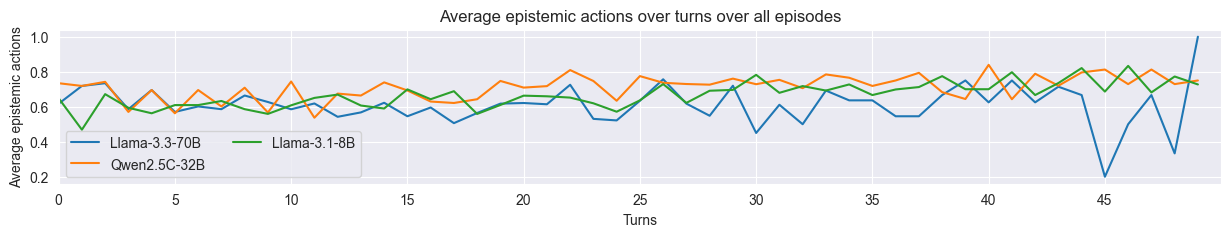

In [2814]:
variants = ["0_home_deliver_three_basic_easy", "1_home_deliver_three_planning_easy", "2_home_deliver_three_basic_easy_invlimittwo",
            "3_home_deliver_three_planning_easy_invlimittwo", "4_home_deliver_three_basic_hard", "5_home_deliver_three_planning_hard",
            "6_home_deliver_three_basic_hard_invlimittwo", "7_home_deliver_three_planning_hard_invlimittwo"]

fig, ax = plt.subplots(figsize=(15, 2))

metric = "epistemic_action"

# ax.plot(get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, metric), label="o3-mini")
# ax.plot(get_avg_turns_score("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, metric), label="Claude3.5")
ax.plot(get_avg_turns_score("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, metric), label="Llama-3.3-70B")
ax.plot(get_avg_turns_score("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, metric), label="Qwen2.5C-32B")
ax.plot(get_avg_turns_score("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants, metric), label="Llama-3.1-8B")

metric_name = "epistemic actions"

ax.set(xlabel='Turns', ylabel=f'Average {metric_name}',
       title=f'Average {metric_name} over turns over all episodes')
# ax.grid()

plt.xlim([0,50])
plt.xticks(np.arange(0, 50, step=5))

# plt.legend()
plt.legend(loc="lower left", ncols=2)

fig.savefig("results/top_models_epistemic_actions_all.pdf", format="pdf", bbox_inches="tight")
fig.savefig("results/top_models_epistemic_actions_all.png")

plt.show()

epistemic_action not in turn 15 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 1_home_deliver_three_planning_easy episode_11
epistemic_action not in turn 21 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 4_home_deliver_three_basic_hard episode_5
epistemic_action not in turn 44 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 5_home_deliver_three_planning_hard episode_10
epistemic_action not in turn 26 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 7_home_deliver_three_planning_hard_invlimittwo episode_14
epistemic_action not in turn 43 of Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0 5_home_deliver_three_planning_hard episode_6
epistemic_action not in turn 8 of Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0 7_home_deliver_three_planning_hard_invlimittwo episode_5


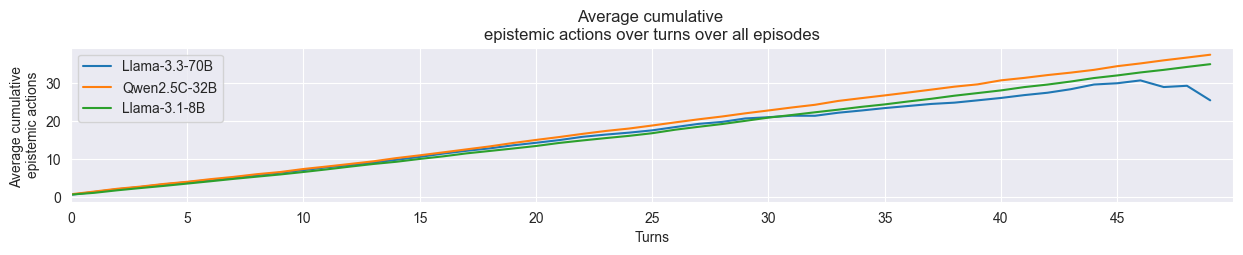

In [2815]:
variants = ["0_home_deliver_three_basic_easy", "1_home_deliver_three_planning_easy", "2_home_deliver_three_basic_easy_invlimittwo",
            "3_home_deliver_three_planning_easy_invlimittwo", "4_home_deliver_three_basic_hard", "5_home_deliver_three_planning_hard",
            "6_home_deliver_three_basic_hard_invlimittwo", "7_home_deliver_three_planning_hard_invlimittwo"]

fig, ax = plt.subplots(figsize=(15, 2))

metric = "epistemic_action"

# ax.plot(get_avg_turns_score_acc("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, metric), label="o3-mini")
# ax.plot(get_avg_turns_score_acc("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, metric), label="Claude3.5")
ax.plot(get_avg_turns_score_acc("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, metric), label="Llama-3.3-70B")
ax.plot(get_avg_turns_score_acc("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, metric), label="Qwen2.5C-32B")
ax.plot(get_avg_turns_score_acc("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants, metric), label="Llama-3.1-8B")

metric_name = "cumulative \nepistemic actions"

ax.set(xlabel='Turns', ylabel=f'Average {metric_name}',
       title=f'Average {metric_name} over turns over all episodes')
# ax.grid()

plt.xlim([0,50])
plt.xticks(np.arange(0, 50, step=5))

plt.legend()

fig.savefig("results/top_models_cumulative_epistemic_actions_all.pdf", format="pdf", bbox_inches="tight")
fig.savefig("results/top_models_cumulative_epistemic_actions_all.png")

plt.show()

effective_epistemic_gain_amount not in turn 15 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 1_home_deliver_three_planning_easy episode_11
effective_epistemic_gain_amount not in turn 21 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 4_home_deliver_three_basic_hard episode_5
effective_epistemic_gain_amount not in turn 44 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 5_home_deliver_three_planning_hard episode_10
effective_epistemic_gain_amount not in turn 26 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 7_home_deliver_three_planning_hard_invlimittwo episode_14
effective_epistemic_gain_amount not in turn 43 of Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0 5_home_deliver_three_planning_hard episode_6
effective_epistemic_gain_amount not in turn 8 of Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0 7_home_deliver_three_planning_hard_invlimittwo episode_5


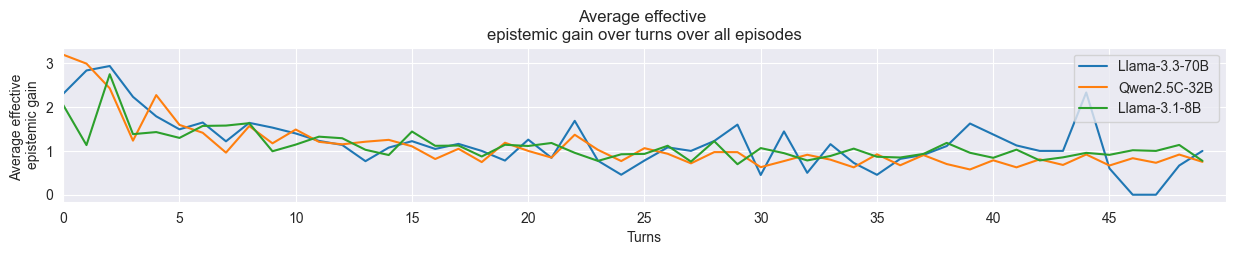

In [2816]:
variants = ["0_home_deliver_three_basic_easy", "1_home_deliver_three_planning_easy", "2_home_deliver_three_basic_easy_invlimittwo",
            "3_home_deliver_three_planning_easy_invlimittwo", "4_home_deliver_three_basic_hard", "5_home_deliver_three_planning_hard",
            "6_home_deliver_three_basic_hard_invlimittwo", "7_home_deliver_three_planning_hard_invlimittwo"]

fig, ax = plt.subplots(figsize=(15, 2))

metric = "effective_epistemic_gain_amount"

# ax.plot(get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, metric), label="o3-mini")
# ax.plot(get_avg_turns_score("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, metric), label="Claude3.5")
ax.plot(get_avg_turns_score("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, metric), label="Llama-3.3-70B")
ax.plot(get_avg_turns_score("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, metric), label="Qwen2.5C-32B")
ax.plot(get_avg_turns_score("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants, metric), label="Llama-3.1-8B")

metric_name = "effective \nepistemic gain"

ax.set(xlabel='Turns', ylabel=f'Average {metric_name}',
       title=f'Average {metric_name} over turns over all episodes')
# ax.grid()

plt.xlim([0,50])
plt.xticks(np.arange(0, 50, step=5))

plt.legend()

plot_tag = "epistemic_gain"
fig.savefig(f"results/top_models_{plot_tag}_all.pdf", format="pdf", bbox_inches="tight")
fig.savefig(f"results/top_models_{plot_tag}_all.png")

plt.show()

effective_epistemic_gain_amount not in turn 15 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 1_home_deliver_three_planning_easy episode_11
effective_epistemic_gain_amount not in turn 21 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 4_home_deliver_three_basic_hard episode_5
effective_epistemic_gain_amount not in turn 44 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 5_home_deliver_three_planning_hard episode_10
effective_epistemic_gain_amount not in turn 26 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 7_home_deliver_three_planning_hard_invlimittwo episode_14
effective_epistemic_gain_amount not in turn 43 of Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0 5_home_deliver_three_planning_hard episode_6
effective_epistemic_gain_amount not in turn 8 of Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0 7_home_deliver_three_planning_hard_invlimittwo episode_5


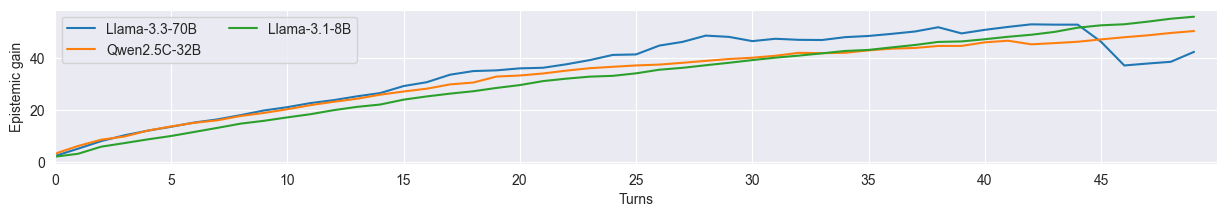

In [2817]:
variants = ["0_home_deliver_three_basic_easy", "1_home_deliver_three_planning_easy", "2_home_deliver_three_basic_easy_invlimittwo",
            "3_home_deliver_three_planning_easy_invlimittwo", "4_home_deliver_three_basic_hard", "5_home_deliver_three_planning_hard",
            "6_home_deliver_three_basic_hard_invlimittwo", "7_home_deliver_three_planning_hard_invlimittwo"]

fig, ax = plt.subplots(figsize=(15, 2))

metric = "effective_epistemic_gain_amount"

# ax.plot(get_avg_turns_score_acc("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, metric), label="o3-mini")
# ax.plot(get_avg_turns_score_acc("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, metric), label="Claude3.5")
ax.plot(get_avg_turns_score_acc("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, metric), label="Llama-3.3-70B")
ax.plot(get_avg_turns_score_acc("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, metric), label="Qwen2.5C-32B")
ax.plot(get_avg_turns_score_acc("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants, metric), label="Llama-3.1-8B")

metric_name = "Epistemic gain"

ax.set(xlabel='Turns', ylabel=f'{metric_name}',
       # title=f'Average {metric_name} over turns over all episodes'
       )
# ax.grid()

plt.xlim([0,50])
plt.xticks(np.arange(0, 50, step=5))

plt.legend(ncols=2)

plot_tag = "cumulative_epistemic_gain"
fig.savefig(f"results/{plot_tag}.pdf", format="pdf", bbox_inches="tight")
fig.savefig(f"results/{plot_tag}.png")

plt.show()

#### Paired epistemic gain and known goal entities plots

In [2818]:
# plart =

known_goal_entities_ratio not in turn 43 of Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0 5_home_deliver_three_planning_hard episode_6
known_goal_entities_ratio not in turn 8 of Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0 7_home_deliver_three_planning_hard_invlimittwo episode_5
known_goal_entities_ratio not in turn 15 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 1_home_deliver_three_planning_easy episode_11
known_goal_entities_ratio not in turn 21 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 4_home_deliver_three_basic_hard episode_5
known_goal_entities_ratio not in turn 44 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 5_home_deliver_three_planning_hard episode_10
known_goal_entities_ratio not in turn 26 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 7_home_deliver_three_planning_hard_invlimittwo episode_14
effective_epistemic_gain_amount not in turn 43 of Qwen2.5-Coder-32B-Instruct-t0.0--Qw

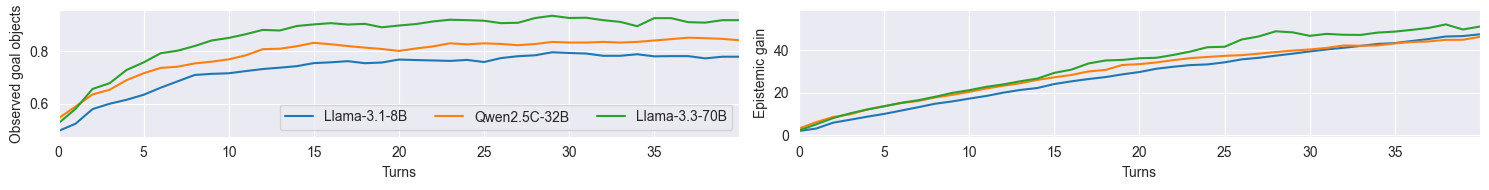

In [2819]:
variants = ["0_home_deliver_three_basic_easy", "1_home_deliver_three_planning_easy", "2_home_deliver_three_basic_easy_invlimittwo",
            "3_home_deliver_three_planning_easy_invlimittwo", "4_home_deliver_three_basic_hard", "5_home_deliver_three_planning_hard",
            "6_home_deliver_three_basic_hard_invlimittwo", "7_home_deliver_three_planning_hard_invlimittwo"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 2))



metric = "known_goal_entities_ratio"

ax1.plot(get_avg_turns_score("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants, metric), label="Llama-3.1-8B")
ax1.plot(get_avg_turns_score("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, metric), label="Qwen2.5C-32B")
ax1.plot(get_avg_turns_score("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, metric), label="Llama-3.3-70B")
# ax1.plot(get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, metric), label="o3-mini")
# ax1.plot(get_avg_turns_score("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, metric), label="Claude3.5")

metric_name = "Observed goal objects"

ax1.set(xlabel='Turns', ylabel=f'{metric_name}',
       # title=f'Average {metric_name} over turns over all episodes'
       )
# ax.grid()

xlim = 40
ax1.set_xlim([0,xlim])
ax1.set_xticks(np.arange(0, xlim, step=5))

ax1.legend(ncols=3)


metric = "effective_epistemic_gain_amount"

ax2.plot(get_avg_turns_score_acc("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants, metric), label="Llama-3.1-8B")
ax2.plot(get_avg_turns_score_acc("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, metric), label="Qwen2.5C-32B")
ax2.plot(get_avg_turns_score_acc("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, metric), label="Llama-3.3-70B")
# ax2.plot(get_avg_turns_score_acc("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, metric), label="o3-mini")
# ax2.plot(get_avg_turns_score_acc("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, metric), label="Claude3.5")

metric_name = "Epistemic gain"

ax2.set(xlabel='Turns', ylabel=f'{metric_name}',
       # title=f'Average {metric_name} over turns over all episodes'
        )
# ax.grid()

xlim = 40
plt.xlim([0,xlim])
plt.xticks(np.arange(0, xlim, step=5))

plt.tight_layout()

fig.savefig("results/exploration_epistemic_paired.pdf", format="pdf", dpi=300, bbox_inches="tight")
# fig.savefig("results/top_models_known_goal_entities_ratio_all.png")

plt.show()

known_goal_entities_ratio not in turn 43 of Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0 5_home_deliver_three_planning_hard episode_6
known_goal_entities_ratio not in turn 8 of Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0 7_home_deliver_three_planning_hard_invlimittwo episode_5
known_goal_entities_ratio not in turn 15 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 1_home_deliver_three_planning_easy episode_11
known_goal_entities_ratio not in turn 21 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 4_home_deliver_three_basic_hard episode_5
known_goal_entities_ratio not in turn 44 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 5_home_deliver_three_planning_hard episode_10
known_goal_entities_ratio not in turn 26 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 7_home_deliver_three_planning_hard_invlimittwo episode_14
effective_epistemic_gain_amount not in turn 43 of Qwen2.5-Coder-32B-Instruct-t0.0--Qw

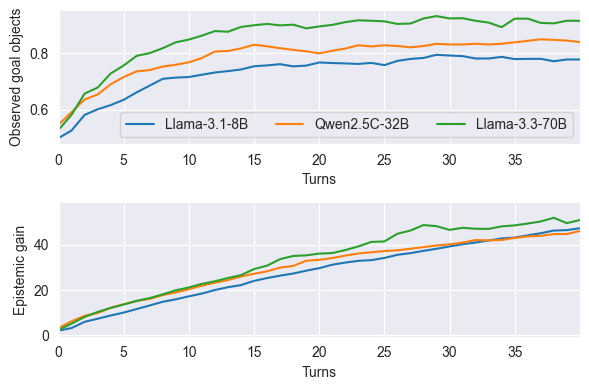

In [2820]:
variants = ["0_home_deliver_three_basic_easy", "1_home_deliver_three_planning_easy", "2_home_deliver_three_basic_easy_invlimittwo",
            "3_home_deliver_three_planning_easy_invlimittwo", "4_home_deliver_three_basic_hard", "5_home_deliver_three_planning_hard",
            "6_home_deliver_three_basic_hard_invlimittwo", "7_home_deliver_three_planning_hard_invlimittwo"]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 4))


metric = "known_goal_entities_ratio"

ax1.plot(get_avg_turns_score("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants, metric), label="Llama-3.1-8B")
ax1.plot(get_avg_turns_score("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, metric), label="Qwen2.5C-32B")
ax1.plot(get_avg_turns_score("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, metric), label="Llama-3.3-70B")
# ax1.plot(get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, metric), label="o3-mini")
# ax1.plot(get_avg_turns_score("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, metric), label="Claude3.5")

metric_name = "Observed goal objects"

ax1.set(xlabel='Turns', ylabel=f'{metric_name}',
       # title=f'Average {metric_name} over turns over all episodes'
       )
# ax.grid()

xlim = 40
ax1.set_xlim([0,xlim])
ax1.set_xticks(np.arange(0, xlim, step=5))

ax1.legend(ncols=3)


metric = "effective_epistemic_gain_amount"

ax2.plot(get_avg_turns_score_acc("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants, metric), label="Llama-3.1-8B")
ax2.plot(get_avg_turns_score_acc("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, metric), label="Qwen2.5C-32B")
ax2.plot(get_avg_turns_score_acc("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, metric), label="Llama-3.3-70B")
# ax2.plot(get_avg_turns_score_acc("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, metric), label="o3-mini")
# ax2.plot(get_avg_turns_score_acc("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, metric), label="Claude3.5")

metric_name = "Epistemic gain"

ax2.set(xlabel='Turns', ylabel=f'{metric_name}',
       # title=f'Average {metric_name} over turns over all episodes'
        )
# ax.grid()

xlim = 40
plt.xlim([0,xlim])
plt.xticks(np.arange(0, xlim, step=5))

plt.tight_layout()

fig.savefig("results/exploration_epistemic_paired_vertical.pdf", format="pdf", dpi=300, bbox_inches="tight")
# fig.savefig("results/top_models_known_goal_entities_ratio_all.png")

plt.show()

#### Compound measures

In [2821]:
variants = ["0_home_deliver_three_basic_easy", "1_home_deliver_three_planning_easy", "2_home_deliver_three_basic_easy_invlimittwo",
            "3_home_deliver_three_planning_easy_invlimittwo", "4_home_deliver_three_basic_hard", "5_home_deliver_three_planning_hard",
            "6_home_deliver_three_basic_hard_invlimittwo", "7_home_deliver_three_planning_hard_invlimittwo"]

# avg_ep_acts = get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, "epistemic_action")
# avg_ep_gain = get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, "effective_epistemic_gain_amount")

In [2822]:
def get_epistemic_effect(model_id: str, variants: list):
    avg_ep_acts = get_avg_turns_score(model_id, variants, "epistemic_action")
    avg_ep_gain = get_avg_turns_score(model_id, variants, "effective_epistemic_gain_amount")

    ep_effect_compound = avg_ep_acts * avg_ep_gain

    return ep_effect_compound

In [2823]:
def get_epistemic_effect_progress_list(model_id: str, variant: str, episode: str):
    ep_acts = get_score_progress_list(model_id, variant, episode, "epistemic_action")
    print(ep_acts)
    ep_gain = get_score_progress_list(model_id, variant, episode, "effective_epistemic_gain_amount")
    print(ep_gain)

    epistemic_effect_progression = ep_acts * ep_gain

    return epistemic_effect_progression

In [2824]:
# get_epistemic_effect_progress_list("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", "0_home_deliver_three_basic_easy", "episode_0")

In [2825]:
def get_avg_turns_score(model_id: str, variants: list, score: str):
    episodes = [f"episode_{number}" for number in range(0,16)]
    list_of_arrays = list()
    for variant in variants:
        for episode in episodes:
            score_progress_list = get_score_progress_list(model_id, variant, episode, score)
            prog_array = np.full(50, np.nan)
            for idx, val in enumerate(score_progress_list):
                prog_array[idx] = val
            list_of_arrays.append(prog_array)

    progress_array = np.array(list_of_arrays)
    averages_array = np.nanmean(progress_array, axis=0)

    return averages_array

epistemic_action not in turn 15 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 1_home_deliver_three_planning_easy episode_11
epistemic_action not in turn 21 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 4_home_deliver_three_basic_hard episode_5
epistemic_action not in turn 44 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 5_home_deliver_three_planning_hard episode_10
epistemic_action not in turn 26 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 7_home_deliver_three_planning_hard_invlimittwo episode_14
effective_epistemic_gain_amount not in turn 15 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 1_home_deliver_three_planning_easy episode_11
effective_epistemic_gain_amount not in turn 21 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 4_home_deliver_three_basic_hard episode_5
effective_epistemic_gain_amount not in turn 44 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 5_home_deliver_three_planning_h

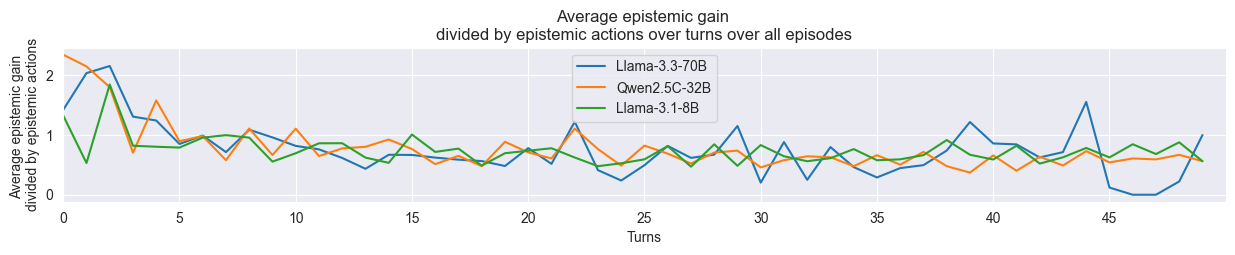

In [2826]:
variants = ["0_home_deliver_three_basic_easy", "1_home_deliver_three_planning_easy", "2_home_deliver_three_basic_easy_invlimittwo",
            "3_home_deliver_three_planning_easy_invlimittwo", "4_home_deliver_three_basic_hard", "5_home_deliver_three_planning_hard",
            "6_home_deliver_three_basic_hard_invlimittwo", "7_home_deliver_three_planning_hard_invlimittwo"]

fig, ax = plt.subplots(figsize=(15, 2))

# ax.plot(get_epistemic_effect("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants), label="o3-mini")
# ax.plot(get_epistemic_effect("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants), label="Claude3.5")
ax.plot(get_epistemic_effect("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants), label="Llama-3.3-70B")
ax.plot(get_epistemic_effect("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants), label="Qwen2.5C-32B")
ax.plot(get_epistemic_effect("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants), label="Llama-3.1-8B")

metric_name = "epistemic gain \ndivided by epistemic actions"

ax.set(xlabel='Turns', ylabel=f'Average {metric_name}',
       title=f'Average {metric_name} over turns over all episodes'
       )
# ax.grid()

plt.xlim([0,50])
plt.xticks(np.arange(0, 50, step=5))

plt.legend()

plot_tag = "epistemic_compound"
fig.savefig(f"results/top_models_{plot_tag}_all.pdf", format="pdf", bbox_inches="tight")
fig.savefig(f"results/top_models_{plot_tag}_all.png")

plt.show()

### old

In [2827]:
# get single episode for exploration line plot
# model_id = "openchat_3.5-GGUF-q8-t0.0--openchat_3.5-GGUF-q8-t0.0"
model_id = 'Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0'
# variant = "0_home_deliver_three_basic_easy"
variant = "2_home_deliver_three_basic_easy_invlimittwo"
# episode = "episode_0"
episode = "episode_2"
with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
    scores = json.load(scores_file)
turn_scores = scores['turn scores']
turns_epistemic = [score_values['epistemic_action'] for score_values in turn_scores.values()]
turns_pragmatic = [score_values['pragmatic_action'] for score_values in turn_scores.values()]
turns_epistemic_gain = [score_values['effective_epistemic_gain_amount'] for score_values in turn_scores.values()]
turns_goal_score = [score_values['goal_score'] for score_values in turn_scores.values()]
turns_resolution_fail = [score_values['action_resolution_fail'] for score_values in turn_scores.values()]
turns_parsing_fail = [score_values['action_parsing_fail'] for score_values in turn_scores.values()]

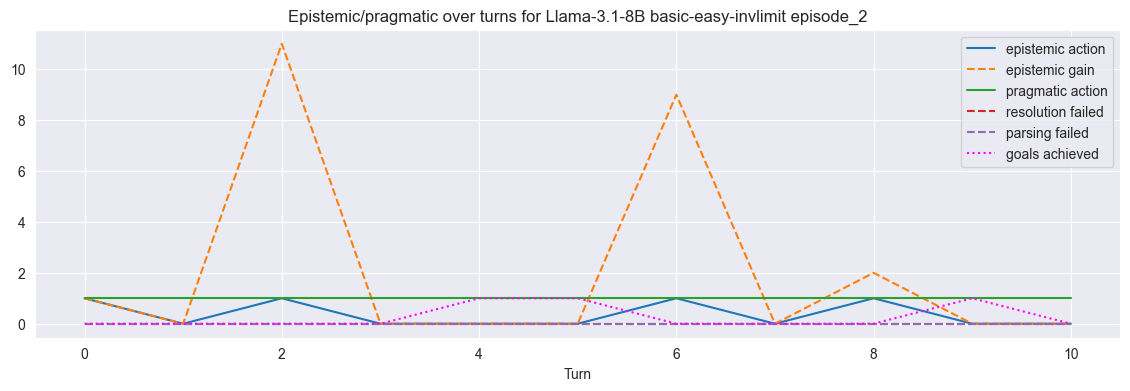

In [2828]:
fig, ax = plt.subplots(figsize=(14, 4))

# ax.plot(turns_known_entities_ratio)
ax.plot(turns_epistemic)
ax.plot(turns_epistemic_gain, linestyle='dashed')
ax.plot(turns_pragmatic)
ax.plot(turns_resolution_fail, linestyle='dashed')
ax.plot(turns_parsing_fail, linestyle='dashed')
ax.plot(turns_goal_score, linestyle='dotted', color='magenta')

ax.set(xlabel='Turn',
       title=f'Epistemic/pragmatic over turns for {model_name_dict[model_id]} {experiment_short_name_dict[variant]} {episode}')
# ax.grid()
ax.legend(['epistemic action', 'epistemic gain', 'pragmatic action', 'resolution failed', 'parsing failed', 'goals achieved'], loc='upper right')

# fig.savefig("test.png")
plt.show()

### Average turns and epistemic/pragmatic actions

In [2829]:
# get single episode for exploration line plot
# model_id = "openchat_3.5-GGUF-q8-t0.0--openchat_3.5-GGUF-q8-t0.0"
model_id = 'Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0'
# variant = "0_home_deliver_three_basic_easy"
variant = "2_home_deliver_three_basic_easy_invlimittwo"
# episode = "episode_0"
episode = "episode_2"
with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
    scores = json.load(scores_file)

In [2830]:
def get_score_over_episodes(model_id, variant, score):
    all_episodes = list()
    if os.path.exists(f"results/{model_id}"):
        for ep_num in range(0,16):
            episode = f"episode_{ep_num}"
            # print(variant, episode)
            episode_score_list = list()
            with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
                scores = json.load(scores_file)
                # print("scores:", scores)
                ep_turn_scores = scores['turn scores']
                for turn_number, turn_dict in ep_turn_scores.items():
                    # print("turn number:", turn_number)
                    # in some cases the score might be missing on the last turn:
                    if score in turn_dict:
                        episode_score_list.append(turn_dict[score])
                all_episodes.append(episode_score_list)
        return all_episodes
    else:
        return []


In [2831]:
epistemic_action_counts = get_score_over_episodes(model_id, variant, "epistemic_action")

In [2832]:
numbers_of_turns = [len(episode_turns) for episode_turns in epistemic_action_counts]
numbers_of_turns

[30, 22, 11, 28, 20, 50, 18, 27, 50, 50, 25, 21, 41, 26, 21, 50]

In [2833]:
numbers_of_epistemic_actions = [sum(episode_turns) for episode_turns in epistemic_action_counts]
numbers_of_epistemic_actions

[14, 12, 4, 16, 12, 25, 9, 10, 33, 32, 13, 10, 23, 10, 11, 33]

In [2834]:
average_number_of_turns = np.average(numbers_of_turns)
average_number_of_turns

30.625

In [2835]:
average_number_of_epistemic_actions = np.average(numbers_of_epistemic_actions)
average_number_of_epistemic_actions

16.6875

In [2836]:
def get_average_score_over_experiments(model_id, score):
    variant_turns_average = list()
    variant_score_averages = list()
    for variant in experiment_short_name_dict.keys():
        variant_scores = get_score_over_episodes(model_id, variant, score)
        numbers_of_turns = [len(episode_turns) for episode_turns in variant_scores]
        numbers_of_scores = [sum(episode_turns) for episode_turns in variant_scores]
        average_number_of_turns = np.average(numbers_of_turns)
        variant_turns_average.append(average_number_of_turns)
        average_number_of_scores = np.average(numbers_of_scores)
        variant_score_averages.append(average_number_of_scores)
    return variant_turns_average, variant_score_averages


In [2837]:
# get_average_score_over_experiments(model_id, "epistemic_action")

In [2838]:
get_average_score_over_experiments("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", "epistemic_action")

([15.5,
  14.0,
  20.5625,
  17.4375,
  27.625,
  27.6875,
  29.6875,
  27.875,
  23.4375,
  41.6875,
  23.4375],
 [8.4375,
  6.625,
  11.25,
  9.0625,
  18.75,
  19.0625,
  18.375,
  19.0625,
  14.3125,
  22.4375,
  8.6875])

In [2839]:
# get averages for all models
def get_average_epistemic_all(model_names = None):
    avg_turns_list = list()
    avg_epistemic_gain_list = list()
    avg_epistemic_actions_list = list()
    avg_plan_viability_list = list()

    if not model_names:
        model_names = model_name_dict.keys()

    for model_id in model_names:
        print(model_id)
        avg_epistemic_scores_tuple = get_average_score_over_experiments(model_id, "effective_epistemic_gain_amount")
        avg_turns = avg_epistemic_scores_tuple[0]
        # print("avg_turns", avg_turns)
        avg_turns_overall = np.average(avg_epistemic_scores_tuple[0])
        # print("avg_turns_overall", avg_turns_overall)
        if not np.isnan(avg_turns_overall):
            avg_turns_list.append(avg_turns_overall)
        avg_epistemic_gain = avg_epistemic_scores_tuple[1]
        avg_epistemic_gain_overall = np.average(avg_epistemic_scores_tuple[1])
        if not np.isnan(avg_epistemic_gain_overall):
            avg_epistemic_gain_list.append(avg_epistemic_gain_overall)
        avg_epistemic_scores_tuple = get_average_score_over_experiments(model_id, "epistemic_action")
        avg_epistemic_actions = avg_epistemic_scores_tuple[1]
        avg_epistemic_actions_overall = np.average(avg_epistemic_scores_tuple[1])
        if not np.isnan(avg_epistemic_actions_overall):
            avg_epistemic_actions_list.append(avg_epistemic_actions_overall)
        avg_plan_viability_tuple = get_average_score_over_experiments(model_id, "plan_command_success_ratio")
        avg_plan_viability = avg_plan_viability_tuple[1]
        avg_plan_viability_overall = np.average(avg_plan_viability_tuple[1])
        if not np.isnan(avg_plan_viability_overall):
            avg_plan_viability_list.append(avg_plan_viability_overall)
    return avg_turns_list, avg_epistemic_gain_list, avg_epistemic_actions_list, avg_plan_viability_list

In [2840]:
# avg_turns_list, avg_epistemic_gain_list, avg_epistemic_actions_list, avg_plan_viability_list = get_average_epistemic_all(top_models)
# print(avg_turns_list)
# print(avg_epistemic_gain_list)
# print(avg_epistemic_actions_list)
# print(avg_plan_viability_list)

# Misc episode detection

## Good planning

In [2841]:
# get_score_progress_list("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", "1_home_deliver_three_planning_easy", "episode_3", "known_entities_ratio")

variants = ["1_home_deliver_three_planning_easy", "3_home_deliver_three_planning_easy_invlimittwo",
           "5_home_deliver_three_planning_hard", "7_home_deliver_three_planning_hard_invlimittwo"]

# variants = ["1_home_deliver_three_planning_easy"]

# get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, "plan_command_success_ratio")

In [2842]:
def get_turn_score_progressions(model_id: str, variants: list, score: str):
    episodes = [f"episode_{number}" for number in range(0,16)]
    # list_of_arrays = list()
    progs_dict = dict()
    for variant in variants:
        progs_dict[variant] = dict()
        for episode in episodes:
            score_progress_list = get_score_progress_list(model_id, variant, episode, score)
            prog_array = np.full(50, np.nan)
            for idx, val in enumerate(score_progress_list):
                prog_array[idx] = val
            # list_of_arrays.append(prog_array)
            progs_dict[variant][episode] = prog_array
    # progress_array = np.array(list_of_arrays)
    # averages_array = np.nanmean(progress_array, axis=0)

    return progs_dict

In [2843]:
variants = ["1_home_deliver_three_planning_easy", "3_home_deliver_three_planning_easy_invlimittwo", "5_home_deliver_three_planning_hard", "7_home_deliver_three_planning_hard_invlimittwo"]

# variants = ["1_home_deliver_three_planning_easy"]
# variants = ["3_home_deliver_three_planning_easy_invlimittwo"]

# o3_plan_progs = get_turn_score_progressions("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, "plan_command_success_ratio")
# o3_plan_progs

In [2844]:
def detect_best_earliest_score(prog_dict: dict, turn_offset_factor: float = 0.1):
    best_eps = list()
    best_score = 0
    best_earliest_eps = list()
    best_earliest_score = 0
    for variant, episodes in prog_dict.items():
        for ep_id, progression in episodes.items():
            for turn_idx in range(50):
                turn_score = progression[turn_idx]
                if turn_score > best_score:
                    best_ep = f"{variant} {ep_id} turn {turn_idx}"
                    best_eps.append(best_ep)
                    best_score = turn_score

                turn_lateness_offset = turn_idx * turn_offset_factor
                turn_offset_score = turn_score - turn_lateness_offset
                if turn_offset_score > best_earliest_score:
                    best_earliest_ep = f"{variant} {ep_id} turn {turn_idx}"
                    best_earliest_eps.append(best_earliest_ep)
                    best_earliest_score = turn_offset_score

    return best_eps, best_earliest_eps

In [2845]:
# detect_best_earliest_score(o3_plan_progs, turn_offset_factor=0.01)

In [2846]:
def detect_best_long_plan(prog_dict: dict, model_id: str):
    best_longest_eps = list()
    best_score = 0
    longest_plan = 0
    highest_go = 0
    for variant, episodes in prog_dict.items():
        for ep_id, progression in episodes.items():

            # load interactions:
            with open(f"results/{model_id}/adventuregame/{variant}/{ep_id}/interactions.json", 'r', encoding='utf-8') as interactions_file:
                ep_interactions = json.load(interactions_file)

            # for turn_idx, turn_acts in enumerate(ep_interactions['turns']):

            ep_plan_lengths = list()
            ep_plan_go_count = list()

            for turn_acts in ep_interactions['turns']:
                for turn_act in turn_acts:
                    if turn_act['action']['type'] == 'plan_length':
                        ep_plan_lengths.append(turn_act['action']['content'])
                    if turn_act['action']['type'] == 'current_plan':
                        go_count = 0
                        split_plan = turn_act['action']['content'][1:-1].replace("'", "").split(", ")
                        # for planned_action in turn_act['action']['content']:
                        for planned_action in split_plan:
                            # print(planned_action)
                            # "go" | "enter" | "return" | "proceed" | "move\
                            if planned_action.startswith(('go', 'move', 'enter', 'return', 'proceed')):
                                go_count += 1
                        ep_plan_go_count.append(go_count)

            # print(variant, ep_id, ep_plan_go_count)

            # print(ep_plan_lengths)

            for turn_idx in range(50):
                long = False
                more_go = False
                if turn_idx < len(ep_plan_lengths):
                    turn_score = progression[turn_idx]
                    if ep_plan_lengths[turn_idx] >= longest_plan:
                        long = True
                        longest_plan = ep_plan_lengths[turn_idx]

                    if ep_plan_go_count[turn_idx] > highest_go:
                        more_go = True
                        highest_go = ep_plan_go_count[turn_idx]

                    plan_turn_score = ep_plan_lengths[turn_idx] * turn_score

                    # if long and more_go and turn_score > best_score:
                    if plan_turn_score > best_score:
                        # if long and plan_turn_score > best_score:
                        best_ep = f"{variant} {ep_id} turn {turn_idx}"
                        best_longest_eps.append(best_ep)
                        # best_score = turn_score
                        best_score = plan_turn_score

    print(best_score, longest_plan)

    return best_longest_eps

In [2847]:
# detect_best_long_plan(o3_plan_progs, "o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0")

## Navigation

In [2848]:
variants = ["0_home_deliver_three_basic_easy", "1_home_deliver_three_planning_easy", "2_home_deliver_three_basic_easy_invlimittwo",
            "3_home_deliver_three_planning_easy_invlimittwo", "4_home_deliver_three_basic_hard", "5_home_deliver_three_planning_hard",
            "6_home_deliver_three_basic_hard_invlimittwo", "7_home_deliver_three_planning_hard_invlimittwo"]

# claude_nav_progs = get_turn_score_progressions('claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0', variants, "no_exit_to")

In [2849]:
def detect_nav_fail_correction(prog_dict: dict, model_id: str):
    corrected_eps = list()
    bad_eps = list()
    double_nav_fails = list()
    prime_examples = list()
    for variant, episodes in prog_dict.items():
        for ep_id, progression in episodes.items():
            single_fail = False
            single_fail_turn = int()

            nav_fail_sum = np.nansum(progression)
            if not 2 > nav_fail_sum > 0:
                single_fail = True

            if nav_fail_sum > 5:
                bad_eps.append(f"{variant} {ep_id}")

            for turn_idx in range(50):
                turn_score = progression[turn_idx]
                if turn_score == 1:
                    # check if next turn is a nav fail too
                    if turn_idx+1 < 50 and progression[turn_idx+1] == 1:
                        double_nav_fails.append(f"{variant} {ep_id}")
                    if single_fail:
                        single_fail_turn = turn_idx

            if not single_fail:
                continue

            # load interactions:
            with open(f"results/{model_id}/adventuregame/{variant}/{ep_id}/interactions.json", 'r', encoding='utf-8') as interactions_file:
                ep_interactions = json.load(interactions_file)

            correct_go_turns = list()

            for turn_idx, turn_acts in enumerate(ep_interactions['turns']):
                for turn_act in turn_acts:
                    if turn_act['action']['type'] == 'action_info':
                        act_content = turn_act['action']['content']
                        if act_content['action_type'] == "go":
                            correct_go_turns.append(turn_idx)

            for later_turn in range(single_fail_turn, len(ep_interactions['turns'])):
                cur_ep = f"{variant} {ep_id}"
                if later_turn in correct_go_turns and cur_ep not in corrected_eps:
                    corrected_eps.append(f"{variant} {ep_id}")

            if single_fail_turn+1 in correct_go_turns and single_fail_turn+2 in correct_go_turns and single_fail_turn+3 in correct_go_turns:
                prime_examples.append(f"{variant} {ep_id} turn {single_fail_turn}")



    return {'corrected': corrected_eps, 'bad': bad_eps, 'double_fails': double_nav_fails, 'prime_examples': prime_examples}

In [2850]:
# detect_nav_fail_correction(claude_nav_progs, 'claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0')